# Analyse des √âv√©nements Bordelais - MeetingPotes


# Cr√©er un nouvel environnement virtuel
python -m venv venv
source venv/bin/activate

# Installer toutes les d√©pendances
pip install -r requirements.txt

# T√©l√©charger les mod√®les spaCy
python -m spacy download fr_core_news_sm
python -m spacy download fr_core_news_md

## Collecte des √âv√©nements Bordelais - Septembre 2025

Objectifs :
- Collecter les donn√©es √©v√©nementielles depuis les sources identifi√©es
- Respecter les bonnes pratiques de web scraping
- Structurer les donn√©es de mani√®re coh√©rente
- Sauvegarder les donn√©es brutes pour le traitement ult√©rieur

In [147]:
# Importations des biblioth√®ques
import requests
from urllib.parse import urlparse, urljoin
import pandas as pd
import hashlib
from bs4 import BeautifulSoup
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
import os
import re
from datetime import datetime
from selenium.common.exceptions import WebDriverException
import requests
from urllib.parse import urlparse, urljoin
import pandas as pd
import hashlib
from bs4 import BeautifulSoup
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
import os
import re
from datetime import datetime
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import WebDriverException
import logging
from typing import List, Dict, Optional, Any
import unicodedata

In [148]:
# Configuration des paths
OUTPUT_DIR = "bordeaux_events"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Sources de Donn√©es S√©lectionn√©es

Nous ciblons des sources officielles et sp√©cialis√©es :



In [149]:
# D√©finition des souces 
SOURCES = [

    {
        'name': 'bordeaux-tourisme',
        'url': 'https://www.bordeaux-tourisme.com/agenda.html?date_start=2025-09-01&date_end=2025-09-30',
        'event_list_selector': '.ListSit-item.js-list-sit-item',
        'event_link_selector': '.Card[href]',
        'pagination_type': 'selenium'
    },
     {
        'name': 'bordeaux-metropole',
        'url': 'https://www.bordeaux-metropole.fr/agenda?timings[gte]=2025-08-31T23:00:00.000Z&timings[lte]=2025-09-30T22:59:59.999Z&timings[tz]=Africa/Tunis',
        'event_list_selector': '.oa-list__item',
        'event_link_selector': '.linkContent[href]',
        'pagination_type': 'selenium'
    },
      {
        'name': 'bordeaux-fr',
        'url': 'https://www.bordeaux.fr/evenements?keywords=&field_datetime_range_1=All&field_datetime_range%5Bmin%5D=2025-09-01&field_datetime_range%5Bmax%5D=2025-09-30&items_per_page=50&sort_bef_combine=field_datetime_range_1_ASC',
        'event_list_selector': '.views-row',
        'event_link_selector': '.teasers-events__caption__title[href]',
        'pagination_type': 'beautifulsoup'
    }, {
        'name': 'guide-bordeaux-gironde',
        'url': 'https://www.guide-bordeaux-gironde.com/fr/agenda.html?dates=2025-09-01%3A2025-09-30',
        'event_list_selector': '.event',
        'event_link_selector': '.event-link[href]',
        'pagination_type': 'beautifulsoup'
    }

 
]


### Respect des "robots.txt" et √©thique WEB

on veut commencer tout d'abord par v√©rifier si on respecte des r√®gles d‚Äôacc√®s fix√©es par le site donc on fait acceder pour chaque source au fichier robots.txt est un fichier plac√© √† la racine d‚Äôun site web(Il sert √† indiquer aux robots d‚Äôindexation (Googlebot, scrapers, etc.) quelles pages ou sections du site sont autoris√©es ou interdites √† la consultation automatique)

In [150]:
def fetch_robots_txt(domain_url, timeout=10):

    parsed = urlparse(domain_url)
    base = f"{parsed.scheme}://{parsed.netloc}"
    robots_url = urljoin(base, "/robots.txt")
    res = {"domain": base, "robots_url": robots_url, "raw": None, "parsed": []}
    try:
        r = requests.get(robots_url, timeout=timeout, headers={"User-Agent": "MeetingPotesScraper/1.0"})
        if r.status_code == 200:
            text = r.text
            res["raw"] = text
            # parse basic lines
            ua = None
            for line in text.splitlines():
                line = line.strip()
                if not line or line.startswith("#"): continue
                if ":" not in line: continue
                k, v = line.split(":", 1)
                k = k.strip().lower(); v = v.strip()
                if k == "user-agent":
                    ua = v
                else:
                    res["parsed"].append({"user_agent": ua or "*", "directive": k, "value": v})
        else:
            res["raw"] = None
            res["http_status"] = r.status_code
    except Exception as e:
        res["error"] = str(e)
    return res

# Exemple d'utilisation sur une liste de domains fournies
sources = [
   'https://www.bordeaux-metropole.fr/agenda?timings%5Bgte%5D=2025-08-31T23%3A00%3A00.000Z&timings%5Blte%5D=2025-09-30T22%3A59%3A59.999Z&timings%5Btz%5D=Africa%2FTunis','https://www.bordeaux-tourisme.com/agenda.html?date_start=2025-09-01&date_end=2025-09-30', 'https://www.bordeaux.fr/evenements?keywords=&field_datetime_range_1=All&field_datetime_range%5Bmin%5D=2025-09-01&field_datetime_range%5Bmax%5D=2025-09-30&items_per_page=50&sort_bef_combine=field_datetime_range_1_ASC','https://www.guide-bordeaux-gironde.com/fr/agenda.html?dates=2025-09-01%3A2025-09-30','https://www.eventbrite.fr/d/france--bordeaux/all-events/?page=1&start_date=2025-09-01&end_date=2025-09-30'
]

robots_results = {}
for s in sources:
    res = fetch_robots_txt(s)
    robots_results[s] = res
    time.sleep(0.2)
with open('robots_analysis_summary.txt', 'w', encoding='utf-8') as f:
    for s, res in robots_results.items():
        st = res.get("http_status", "200" if res.get("raw") else "N/A")
        parsed_count = len(res.get("parsed", []))
        err = res.get("error", "None")
        line = f"{s} -> status: {st}, parsed_lines: {parsed_count}, error: {err}\n"
        print(line, end='')  # Afficher dans la console
        f.write(line)  # √âcrire dans le fichier


https://www.bordeaux-metropole.fr/agenda?timings%5Bgte%5D=2025-08-31T23%3A00%3A00.000Z&timings%5Blte%5D=2025-09-30T22%3A59%3A59.999Z&timings%5Btz%5D=Africa%2FTunis -> status: 200, parsed_lines: 42, error: None
https://www.bordeaux-tourisme.com/agenda.html?date_start=2025-09-01&date_end=2025-09-30 -> status: 200, parsed_lines: 52, error: None
https://www.bordeaux.fr/evenements?keywords=&field_datetime_range_1=All&field_datetime_range%5Bmin%5D=2025-09-01&field_datetime_range%5Bmax%5D=2025-09-30&items_per_page=50&sort_bef_combine=field_datetime_range_1_ASC -> status: 200, parsed_lines: 31, error: None
https://www.guide-bordeaux-gironde.com/fr/agenda.html?dates=2025-09-01%3A2025-09-30 -> status: 200, parsed_lines: 25, error: None
https://www.eventbrite.fr/d/france--bordeaux/all-events/?page=1&start_date=2025-09-01&end_date=2025-09-30 -> status: 200, parsed_lines: 192, error: None


In [151]:
# ---------- Utilitaires ----------

def save_to_json(data, filename):
    """Sauvegarde des donn√©es scrapp√©es des √©vennements au format JSON"""
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def save_to_csv(data, filename):
    """Sauvegarde des donn√©es scrapp√©es des √©vennements au format CSV"""
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False, encoding='utf-8')

def init_selenium_driver():
    """Initialise et retourne un driver Selenium"""
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
    
    try:
        driver = webdriver.Chrome(options=options)
        return driver
    except WebDriverException:
        logger.error("ChromeDriver non disponible")
        return None
#Gestion de la Navigation
def get_page_content(url, use_selenium=False, driver=None):
    """R√©cup√®re le contenu HTML d'une URL"""
    if use_selenium and driver:
        try:
            driver.get(url)
            time.sleep(3)
            return driver.page_source, driver
        except Exception as e:
            logger.error(f"Erreur Selenium avec {url}: {e}")
            return None, None
    else:
        try:
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()
            return response.text, None
        except Exception as e:
            logger.error(f"Erreur Requests avec {url}: {e}")
            return None, None

def extract_text(soup, selector):
    """Extrait le texte d'un s√©lecteur CSS"""
    element = soup.select_one(selector)
    return element.get_text(strip=True) if element else None

def extract_attr(soup, selector, attr):
    """Extrait un attribut d'un s√©lecteur CSS"""
    element = soup.select_one(selector)
    return element[attr] if element and element.has_attr(attr) else None
# Gestion des Cookies et Popups
def handle_cookies(driver):
    """G√®re les popups de cookies des sitewebs"""
    try:
        cookie_buttons = driver.find_elements(
            By.XPATH, 
            "//button[contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'accepter') or "
            "contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'ok') or "
            "contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'accept')]"
        )
        
        for button in cookie_buttons:
            try:
                button.click()
                time.sleep(1)
                break
            except:
                continue
    except Exception as e:
        logger.error(f"Erreur lors de la gestion des cookies: {e}")

def handle_pagination_bordeaux_fr(html, base_url, css_selector, link_selector, max_pages=20):
    """G√®re la pagination sp√©cifique pour Bordeaux.fr"""
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} √©v√©nements trouv√©s sur la page {page_count}")
        
        # Trouver le lien vers la page suivante (Bordeaux.fr utilise souvent une pagination Drupal)
        soup = BeautifulSoup(current_html, 'html.parser')
        next_link = soup.select_one('.pager__item--next a, a[rel="next"], li.pager-next a, .pager-next a')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # R√©cup√©rer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(2)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))

# EXTRACTION DES URLs D'√âV√âNEMENTS
def extract_event_urls_from_page(html, base_url, css_selector, link_selector):
    """Extrait les URLs d'√©v√©nements d'une page HTML"""
    soup = BeautifulSoup(html, 'html.parser')
    event_elements = soup.select(css_selector)
    
    event_urls = []
    for element in event_elements:
        link = element.select_one(link_selector)
        if link and link.get('href'):
            event_url = urljoin(base_url, link['href'])
            # Filtrer les URLs non valides
            if event_url.startswith(('http://', 'https://')):
                event_urls.append(event_url)
    
    return event_urls
def handle_pagination_selenium(driver, base_url, css_selector, link_selector, max_pages=10):
    """G√®re la pagination avec Selenium"""
    all_event_urls = []
    page_count = 1
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        current_html = driver.page_source
        event_urls = extract_event_urls_from_page(current_html, base_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} √©v√©nements trouv√©s sur la page {page_count}")
        
        # Essayer de trouver et cliquer sur le bouton suivant
        try:
            next_buttons = driver.find_elements(
                By.XPATH, 
                "//a[contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'suivant') or "
                "contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'next') or "
                "contains(@class, 'next') or contains(@rel, 'next')]"
            )
            
            if next_buttons:
                next_buttons[0].click()
                time.sleep(3)
                page_count += 1
            else:
                print("Plus de pages √† traiter.")
                break
                
        except Exception as e:
            print(f"Erreur lors de la navigation: {e}")
            break
    
    return list(set(all_event_urls))  # Supprimer les doublons
def handle_pagination_bordeaux_fr(html, base_url, css_selector, link_selector, max_pages=20):
    """G√®re la pagination sp√©cifique pour Bordeaux.fr"""
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} √©v√©nements trouv√©s sur la page {page_count}")
        
        # Trouver le lien vers la page suivante (Bordeaux.fr utilise souvent une pagination Drupal)
        soup = BeautifulSoup(current_html, 'html.parser')
        next_link = soup.select_one('.pager__item--next a, a[rel="next"], li.pager-next a, .pager-next a')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # R√©cup√©rer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(2)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))

def handle_pagination_guide_bordeaux_gironde(html, base_url, css_selector, link_selector, max_pages=111):
    """G√®re la pagination sp√©cifique pour Guide Bordeaux Gironde"""
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} √©v√©nements trouv√©s sur la page {page_count}")
        
        # Trouver le lien vers la page suivante
        soup = BeautifulSoup(current_html, 'html.parser')
        next_link = None
        
        # Chercher le lien de la page suivante dans la pagination
        pagination_links = soup.select('.navigBarre a.num, .navigBarre a.next')
        for link in pagination_links:
            link_text = link.get_text(strip=True)
            if link_text.isdigit() and int(link_text) == page_count + 1:
                next_link = link
                break
        
        if not next_link:
            # Chercher le bouton "suivant"
            next_link = soup.select_one('.navigBarre a.next')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # R√©cup√©rer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(2)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))

def handle_pagination_beautifulsoup(html, base_url, css_selector, link_selector, max_pages=10):
    """G√®re la pagination avec BeautifulSoup"""
    # D√©tecter le type de site
    soup = BeautifulSoup(html, 'html.parser')
    
    # Bordeaux.fr (Drupal)
    if soup.select_one('.view--display-events') or 'bordeaux.fr' in base_url:
        return handle_pagination_bordeaux_fr(html, base_url, css_selector, link_selector, max_pages)
    if soup.select_one('.eventList') or 'guide-bordeaux-gironde.com' in base_url:
        return handle_pagination_guide_bordeaux_gironde(html, base_url, css_selector, link_selector, max_pages)
    
    # Pagination standard pour les autres sites
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} √©v√©nements trouv√©s sur la page {page_count}")
        
        # Trouver le lien vers la page suivante
        next_link = soup.select_one('a.next, a[rel="next"], .pagination-next, .next-page')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # R√©cup√©rer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(1)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))


### EXTRACTION DES D√âTAILS DES √âV√âNEMENTS:Approche Sp√©cifique par Source


In [152]:


def extract_event_details_bourdeaux_tourisme(html, event_url, source_name):
    """Extrait les d√©tails complets d'un √©v√©nement depuis la page HTML"""
    soup = BeautifulSoup(html, 'html.parser')
    
    # G√©n√©rer un ID unique pour l'√©v√©nement
    event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]
    
    # Extraire chaque information
    event_data = {
        'event_id': f"{source_name}_{event_id}",
        'title': extract_text(soup, 'h1, .event-title, .title, .SitIntro-title') or "",
        'description': extract_description_bourdeaux_tourisme(soup) or "",
        'date': extract_date_info_bourdeaux_tourisme(soup) or "",
        'time': extract_time_info_bourdeaux_tourisme(soup) or "",
        'location': extract_text(soup, '.event-location, .location, .place, address strong') or "",
        'address': extract_address_bourdeaux_tourisme(soup) or "",
        'category': extract_categories_bourdeaux_tourisme(soup),
        'tags': extract_tags_bourdeaux_tourisme(soup),
        'price': extract_price_bourdeaux_tourisme(soup) or "",
        'ticket_url': extract_ticket_url_bourdeaux_tourisme(soup) or "",
        'organizer': extract_organizer_bourdeaux_tourisme(soup) or "",
        'image_url': extract_image_url_bourdeaux_tourisme(soup) or "",
        'source': source_name,
        'source_url': event_url,
        'scraped_at': datetime.now().isoformat()
    }
    
    return {k: v for k, v in event_data.items() if v is not None and v != "" and v != []}

def extract_description_bourdeaux_tourisme(soup):
    """Extrait la description de l'√©v√©nement"""
    selectors = [
        '.event-description, .description, .content, .SitIntro-container p',
        'meta[property="og:description"]',
        'meta[name="description"]'
    ]
    
    for selector in selectors:
        if selector.startswith('meta'):
            meta = soup.find('meta', {'property': selector.split('[')[1].split(']')[0]}) or soup.find('meta', {'name': selector.split('[')[1].split(']')[0]})
            if meta and meta.get('content'):
                return meta['content']
        else:
            element = soup.select_one(selector)
            if element:
                return element.get_text(strip=True)
    
    return ""

def extract_date_info_bourdeaux_tourisme(soup):
    """Extrait les informations de date"""
    date_text = extract_text(soup, '.event-date, .date, .Card-label, .SitIntro-date')
    return date_text or ""

def extract_time_info_bourdeaux_tourisme(soup):
    """Extrait les informations horaires"""
    time_text = extract_text(soup, '.event-time, .time, .SitCalendar-day span:nth-child(2)')
    return time_text or ""

def extract_address_bourdeaux_tourisme(soup):
    """Extrait l'adresse compl√®te"""
    address_element = soup.select_one('address, .event-address, .address')
    if address_element:
        return address_element.get_text(separator=' ', strip=True)
    return ""

def extract_categories_bourdeaux_tourisme(soup):
    """Extrait les cat√©gories de l'√©v√©nement"""
    meta_element = soup.select_one('.SitIntro-meta, .event-category, .category')
    if meta_element:
        return [tag.strip() for tag in meta_element.get_text().split(',')]
    return []

def extract_tags_bourdeaux_tourisme(soup):
    """Extrait les mots-cl√©s/tags"""
    tags = []
    
    # M√©ta keywords
    meta_keywords = soup.find('meta', {'name': 'keywords'})
    if meta_keywords and meta_keywords.get('content'):
        tags.extend([tag.strip() for tag in meta_keywords['content'].split(',')])
    
    return tags

def extract_price_bourdeaux_tourisme(soup):
    """Extrait les informations de prix"""
    price_element = soup.select_one('.event-price, .price, .tarif')
    if price_element:
        return price_element.get_text(strip=True)
    
    # Chercher dans tout le texte
    text = soup.get_text()
    price_pattern = r'\d+\s*‚Ç¨'
    prices = re.findall(price_pattern, text)
    return prices[0] if prices else ""

def extract_ticket_url_bourdeaux_tourisme(soup):
    """Extrait l'URL de r√©servation"""
    reservation_btn = soup.select_one('.SitMap-button a[href]')
    if reservation_btn:
        href = reservation_btn.get('href')
        if href and not href.startswith(('javascript:', '#')):
            return href
    
    reservation_links = soup.select('a[href*="reserv"], a[href*="book"], a[href*="billet"], a[href*="eventbrite"], a[href*="weezevent"]')
    for link in reservation_links:
        href = link.get('href')
        if href and not href.startswith(('javascript:', '#')):
            return href
    
    return ""

def extract_organizer_bourdeaux_tourisme(soup):
    """Extrait le nom de l'organisateur"""
    organizer_element = soup.select_one('.event-organizer, .organizer')
    if organizer_element:
        return organizer_element.get_text(strip=True)
    
    return ""

def extract_image_url_bourdeaux_tourisme(soup):
    """Extrait l'URL de l'image principale"""
    image_element = soup.select_one('.event-image img, .main-image img, .Slider-slide img')
    if image_element and image_element.get('src'):
        return image_element['src']
    
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return ""




In [153]:
def extract_event_details_bordeaux_metropole(html, event_url, source_name):
    """Extrait les d√©tails complets d'un √©v√©nement depuis la page HTML"""
    soup = BeautifulSoup(html, 'html.parser')
    
    # G√©n√©rer un ID unique pour l'√©v√©nement
    event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]
    
    # Extraire chaque information
    event_data = {
        'event_id': f"{source_name}_{event_id}",
        'title': extract_text(soup, '.OpenAgenda-Full-title h1') or "",
        'description': extract_description_bordeaux_metropole(soup) or "",
        'date': extract_date_info_bordeaux_metropole(soup) or "",
        'time': extract_time_info_bordeaux_metropole(soup) or "",
        'location': extract_text(soup, '.OpenAgenda-Full-city') or "",
        'address': extract_address_bordeaux_metropole(soup) or "",
        'category': extract_categories_bordeaux_metropole(soup),
        'tags': extract_tags_bordeaux_metropole(soup),
        'price': extract_price_bordeaux_metropole(soup) or "free",
        'ticket_url': extract_ticket_url_bordeaux_metropole(soup) or "",
        'organizer': extract_organizer_bordeaux_metropole(soup) or "",
        'image_url': extract_image_url_bordeaux_metropole(soup) or "",
        'source': source_name,
        'source_url': event_url,
        'scraped_at': datetime.now().isoformat()
    }
    
    return {k: v for k, v in event_data.items() if v is not None and v != "" and v != []}

def extract_description_bordeaux_metropole(soup):
    """Extrait la description de l'√©v√©nement"""
    # Section principale
    desc = soup.select_one('.OpenAgenda-description')
    if desc:
        return desc.get_text(" ", strip=True)
    
    # Meta description (fallback)
    meta = soup.find('meta', {'name': 'description'}) or soup.find('meta', {'property': 'og:description'})
    if meta and meta.get('content'):
        return meta['content']
    
    return ""

def extract_date_info_bordeaux_metropole(soup):
    """Extrait les informations de date"""
    date_element = soup.select_one('.OpenAgenda-Full-date')
    if date_element:
        return date_element.get_text(strip=True)
    return ""

def extract_time_info_bordeaux_metropole(soup):
    """Extrait les informations horaires"""
    time_element = soup.select_one('.OpenAgenda-Full-schedule')
    if time_element:
        return time_element.get_text(" ", strip=True).replace("Horaires", "").strip()
    return ""

def extract_address_bordeaux_metropole(soup):
    """Extrait l'adresse compl√®te"""
    address_element = soup.select_one('.OpenAgenda-Full-address')
    if address_element:
        return address_element.get_text(" ", strip=True).replace("Adresse", "").strip()
    return ""

def extract_categories_bordeaux_metropole(soup):
    """Extrait les cat√©gories de l'√©v√©nement"""
    return []

def extract_tags_bordeaux_metropole(soup):
    """Extrait les mots-cl√©s/tags depuis meta keywords"""
    tags = []
    meta_keywords = soup.find('meta', {'name': 'keywords'})
    if meta_keywords and meta_keywords.get('content'):
        tags.extend([tag.strip() for tag in meta_keywords['content'].split(',')])
    return tags

def extract_price_bordeaux_metropole(soup):
    """Extrait les informations de prix"""
    price_element = soup.select_one('.OpenAgenda-Full-conditions')
    if price_element:
        return price_element.get_text(" ", strip=True).replace("Tarif", "").strip()
    return ""

def extract_ticket_url_bordeaux_metropole(soup):
    """Extrait l'URL d'inscription"""
    ticket_element = soup.select_one('.OpenAgenda-Full-Registration a[href]')
    if ticket_element:
        return ticket_element.get('href')
    return ""

def extract_organizer_bordeaux_metropole(soup):
    """Extrait l'organisateur de l'√©v√©nement"""
    return ""

def extract_image_url_bordeaux_metropole(soup):
    """Extrait l'URL de l'image principale"""
    image_element = soup.select_one('.OpenAgenda-Full-main img')
    if image_element and image_element.get('src'):
        return image_element['src']
    
    # Fallback og:image
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return ""

In [154]:
import re
from bs4 import BeautifulSoup
import hashlib
from datetime import datetime

def extract_bordeaux_fr_title(soup):
    """Extrait le titre de l'√©v√©nement pour Bordeaux.fr"""
    title_element = soup.select_one('.node-event-single__header__title, h1.title-h1')
    if title_element:
        return title_element.get_text(strip=True)
    
    meta_title = soup.find('meta', property='og:title')
    if meta_title and meta_title.get('content'):
        return meta_title['content']
    
    return None

def extract_bordeaux_fr_description(soup):
    """Extrait la description de l'√©v√©nement - seulement les paragraphes"""
    description_parts = []
    
    # Extraire uniquement les paragraphes de la description principale
    desc_elements = soup.select('.node-event-single__body__desc.rich-text p')
    for p in desc_elements:
        text = p.get_text(strip=True)
        # √âviter les textes de r√©servation
        if not any(keyword in text.lower() for keyword in ['r√©servez', 'reservation', 'billetterie']):
            description_parts.append(text)
    
    return ' '.join(description_parts) if description_parts else None

def extract_bordeaux_fr_date_range(soup):
    """Extrait la plage de dates depuis les spans start-date et end-date"""
    start_date = soup.select_one('span.start-date')
    end_date = soup.select_one('span.end-date')
    
    if start_date and end_date:
        return f"{start_date.get_text(strip=True)} {end_date.get_text(strip=True)}"
    
    # Fallback: calculer √† partir des dates d√©taill√©es
    dates = extract_bordeaux_fr_detailed_dates_scheduler(soup)
    if dates:
        first_date = dates[0]['date']
        last_date = dates[-1]['date']
        return f"Du {first_date} au {last_date}"
    
    return None

def extract_bordeaux_fr_detailed_dates_scheduler(soup):
    """Extrait les dates d√©taill√©es avec le format structur√© demand√©"""
    dates_list = []
    dates_element = soup.select_one('#collapse-event-dates .accordion__container')
    
    if dates_element:
        for li in dates_element.find_all('li'):
            date_text = li.get_text(strip=True)
            
            # Pattern pour extraire les informations
            pattern = r'(\w+)\s+(\d{1,2}\s+\w+\s+\d{4})\s+de\s+(\d{1,2}h\d{0,2})\s+√†\s+(\d{1,2}h\d{0,2})'
            match = re.match(pattern, date_text)
            
            if match:
                weekday = match.group(1)  # Vendredi, Samedi, etc.
                date_str = match.group(2)  # 4 avril 2025
                start_time = match.group(3)  # 14h00
                end_time = match.group(4)    # 20h00
                
                dates_list.append({
                    "date": date_str,
                    "weekday": weekday,
                    "start_time": start_time,
                    "end_time": end_time
                })
    
    return dates_list if dates_list else None

def extract_bordeaux_fr_time_summary(soup):
    """Extrait un r√©sum√© des horaires types"""
    dates = extract_bordeaux_fr_detailed_dates_scheduler(soup)
    if not dates:
        return None
    
    # Regrouper par plages horaires similaires
    time_slots = {}
    for date in dates:
        time_key = f"{date['start_time']}-{date['end_time']}"
        if time_key not in time_slots:
            time_slots[time_key] = 0
        time_slots[time_key] += 1
    
    # Retourner les plages horaires les plus fr√©quentes
    if time_slots:
        return ', '.join([f"{key.split('-')[0]} √† {key.split('-')[1]}" 
                         for key in sorted(time_slots.keys(), 
                                         key=lambda x: time_slots[x], reverse=True)[:3]])
    
    return None

def extract_bordeaux_fr_location(soup):
    """Extrait le lieu de l'√©v√©nement"""
    location_element = soup.select_one('.paragraph-container__border__wrapper__element .title')
    if location_element:
        return location_element.get_text(strip=True)
    return None

def extract_bordeaux_fr_address(soup):
    """Extrait l'adresse compl√®te"""
    address_elements = soup.select('.paragraph-container__border__wrapper__element .address')
    if address_elements:
        return ', '.join([addr.get_text(strip=True) for addr in address_elements])
    return None

def extract_bordeaux_fr_categories(soup):
    """Extrait les cat√©gories"""
    categories = []
    tag_elements = soup.select('.node-event-single__header__tags .node-tags__item a')
    for tag in tag_elements:
        categories.append(tag.get_text(strip=True))
    return categories if categories else None

def extract_bordeaux_fr_tags(soup):
    """Extrait les mots-cl√©s/tags"""
    tags = extract_bordeaux_fr_categories(soup) or []
    content = soup.get_text()
    potential_tags = ['r√©alit√© virtuelle', 'patrimoine', 'culture', 'visite', 'exposition', 
                     'immersif', 'm√©di√©val', 'histoire']
    for tag in potential_tags:
        if tag.lower() in content.lower():
            tags.append(tag)
    return list(set(tags)) if tags else None

def extract_bordeaux_fr_price(soup):
    """Extrait le prix"""
    price_section = soup.select_one('#collapse-conditions .accordion__container')
    if price_section:
        price_text = price_section.get_text(strip=True)
        if '‚Ç¨' in price_text:
            return price_text
    return None

def extract_bordeaux_fr_ticket_url(soup):
    """Extrait l'URL de r√©servation"""
    reservation_section = soup.select_one('#collapse-registration-tool a[href]')
    if reservation_section:
        return reservation_section.get('href')
    return None

def extract_bordeaux_fr_organizer(soup):
    """Extrait l'organisateur"""
    location = extract_bordeaux_fr_location(soup)
    if location and "Eclipso" in location:
        return location
    return "Ville de Bordeaux"

def extract_bordeaux_fr_image(soup):
    """Extrait l'URL de l'image principale"""
    main_image = soup.select_one('.node-event-single__body__main-image img')
    if main_image and main_image.get('src'):
        return main_image['src']
    
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return None

def extract_bordeaux_fr_public(soup):
    """Extrait les informations sur le public cible"""
    public_element = soup.select_one('#collapse-public .accordion__container')
    if public_element:
        return public_element.get_text(strip=True)
    return None

def extract_event_details_bourdeaux_fr(html, event_url):
    """Extrait les d√©tails sp√©cifiques pour Bordeaux.fr - version am√©lior√©e"""
    soup = BeautifulSoup(html, 'html.parser')
    
    event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]
    
    # Extraire les dates d√©taill√©es structur√©es
    detailed_dates = extract_bordeaux_fr_detailed_dates_scheduler(soup)
    
    event_data = {
        'event_id': f"bordeaux-fr_{event_id}",
        'title': extract_bordeaux_fr_title(soup),
        'description': extract_bordeaux_fr_description(soup),
        'date': extract_bordeaux_fr_date_range(soup),  # Plage de dates format√©e
        'time': extract_bordeaux_fr_time_summary(soup),  # R√©sum√© des horaires
        'location': extract_bordeaux_fr_location(soup),
        'address': extract_bordeaux_fr_address(soup),
        'category': extract_bordeaux_fr_categories(soup),
        'tags': extract_bordeaux_fr_tags(soup),
        'price': extract_bordeaux_fr_price(soup),
        'ticket_url': extract_bordeaux_fr_ticket_url(soup),
        'organizer': extract_bordeaux_fr_organizer(soup),
        'image_url': extract_bordeaux_fr_image(soup),
        'public_info': extract_bordeaux_fr_public(soup),
        'schedule': detailed_dates,  # Dates d√©taill√©es structur√©es
        'source': 'bordeaux-fr',
        'source_url': event_url,
        'scraped_at': datetime.now().isoformat()
    }
    
    # Nettoyer les donn√©es (supprimer les valeurs None)
    return {k: v for k, v in event_data.items() if v is not None}

In [155]:
def extract_guide_bordeaux_gironde_title(soup):
    """Extrait le titre de l'√©v√©nement pour Guide Bordeaux Gironde"""
    title_element = soup.select_one('.titlePage h1, h1')
    if title_element:
        return title_element.get_text(strip=True)
    
    # Fallback pour les meta donn√©es
    meta_title = soup.find('meta', property='og:title')
    if meta_title and meta_title.get('content'):
        return meta_title['content']
    
    return None

def extract_guide_bordeaux_gironde_description(soup):
    """Extrait la description compl√®te de l'√©v√©nement pour Guide Bordeaux Gironde"""
    description_parts = []

    # S√©lectionne le bloc principal de description
    desc_container = soup.select_one('.richContent.event-details')
    if desc_container:
        # On prend seulement les <p> sans contact, maj ou cr√©dits
        for p in desc_container.find_all('p'):
            if not p.get('class') or not any(c in ['event-contact', 'event-maj', 'event-credit'] for c in p.get('class')):
                description_parts.append(p.get_text(" ", strip=True))

    # Fallback sur anciens s√©lecteurs si jamais le format change
    if not description_parts:
        desc_element = soup.select_one('.event-description, .content-text, .rich-text')
        if desc_element:
            description_parts.append(desc_element.get_text(" ", strip=True))

    return ' '.join(description_parts) if description_parts else None


def extract_guide_bordeaux_gironde_date(soup):
    """Extrait les dates de l'√©v√©nement pour Guide Bordeaux Gironde"""
    # Date dans l'en-t√™te
    date_element = soup.select_one('.event-header-periode .lib')
    if date_element:
        return date_element.get_text(strip=True)
    
    # Chercher dans le contenu
    content = soup.get_text()
    date_pattern = r'\d{1,2}\s+\w+\s+\d{4}'
    dates = re.findall(date_pattern, content)
    if dates:
        return dates[0]
    
    return None

def extract_guide_bordeaux_gironde_time(soup):
    """Extrait les horaires de l'√©v√©nement pour Guide Bordeaux Gironde"""
    # Chercher les horaires dans le contenu
    content = soup.get_text()
    time_pattern = r'\d{1,2}h\d{0,2}'
    times = re.findall(time_pattern, content)
    if times:
        return ', '.join(times)
    
    return None

def extract_guide_bordeaux_gironde_location(soup):
    """Extrait le lieu de l'√©v√©nement pour Guide Bordeaux Gironde"""
    # Lieu dans l'en-t√™te
    location_element = soup.select_one('.event-header-location .lib')
    if location_element:
        return location_element.get_text(strip=True)
    
    # Chercher dans le contenu
    content = soup.get_text()
    location_keywords = ['√†', 'au', 'dans', 'sur']
    for keyword in location_keywords:
        pattern = fr"{keyword}\s+([A-Za-z√Ä-√ø\-'\s]+)(?=\.|,|$)"
        matches = re.findall(pattern, content, re.IGNORECASE)
        if matches:
            return matches[0].strip()
    
    return None

def extract_guide_bordeaux_gironde_address(soup):
    """Extrait l'adresse compl√®te pour Guide Bordeaux Gironde"""
    # Chercher l'adresse dans le contenu
    content = soup.get_text()
    address_pattern = r'\d+\s+[A-Za-z√Ä-√ø\s]+,?\s*\d{5}\s+[A-Za-z√Ä-√ø\s]+'
    addresses = re.findall(address_pattern, content)
    if addresses:
        return addresses[0]
    
    return None

def extract_guide_bordeaux_gironde_categories(soup):
    """Extrait les cat√©gories pour Guide Bordeaux Gironde"""
    categories = []
    
    # Cat√©gories dans le fil d'Ariane
    ariane_elements = soup.select('.ariane a.item-bt')
    for element in ariane_elements:
        text = element.get_text(strip=True)
        if text and text not in ['Accueil', 'Agenda']:
            categories.append(text)
    
    return categories if categories else None

def extract_guide_bordeaux_gironde_tags(soup):
    """Extrait les mots-cl√©s/tags pour Guide Bordeaux Gironde"""
    tags = extract_guide_bordeaux_gironde_categories(soup)
    
    # Ajouter des tags bas√©s sur le contenu
    content = soup.get_text()
    potential_tags = ['patrimoine', 'culture', 'visite', 'exposition', 'concert', 'festival', 
                     'spectacle', 'sport', 'animation', 'd√©gustation', 'march√©', 'vin']
    
    for tag in potential_tags:
        if tag.lower() in content.lower():
            if tags is None:
                tags = []
            tags.append(tag)
    
    return list(set(tags)) if tags else None

def extract_guide_bordeaux_gironde_price(soup):
    """Extrait le prix de l'√©v√©nement pour Guide Bordeaux Gironde"""
    # Chercher dans tout le contenu
    content = soup.get_text()
    price_patterns = [
        r'gratuit', r'payant', r'entr√©e\s*:\s*\d+\s*‚Ç¨', r'\d+\s*‚Ç¨', 
        r'tarif\s*:\s*\d+', r'prix\s*:\s*\d+', r'(\d+)\s*euros?'
    ]
    
    for pattern in price_patterns:
        matches = re.findall(pattern, content, re.IGNORECASE)
        if matches:
            return matches[0] if isinstance(matches[0], str) else f"{matches[0]} ‚Ç¨"
    
    return None

def extract_guide_bordeaux_gironde_ticket_url(soup):
    """Extrait l'URL de r√©servation pour Guide Bordeaux Gironde"""
    # Chercher des liens de r√©servation
    reservation_links = soup.select('a[href*="reservation"], a[href*="billetterie"], a[href*="booking"]')
    for link in reservation_links:
        href = link.get('href')
        if href:
            return href
    
    # Chercher dans le contenu
    content = soup.get_text()
    url_pattern = r'https?://[^\s]+'
    urls = re.findall(url_pattern, content)
    for url in urls:
        if any(keyword in url.lower() for keyword in ['reservation', 'billetterie', 'booking']):
            return url
    
    return None

def extract_guide_bordeaux_gironde_organizer(soup):
    """Extrait l'organisateur pour Guide Bordeaux Gironde"""
    # Par d√©faut
    organizer = "Guide Bordeaux Gironde"
    
    # Chercher dans le contenu
    content = soup.get_text()
    organizer_patterns = [
        r'organis√© par\s+([^\.]+)',
        r'par\s+([^\.]+)',
        r'contact\s*:\s*([^\.]+)'
    ]
    
    for pattern in organizer_patterns:
        matches = re.findall(pattern, content, re.IGNORECASE)
        if matches:
            return matches[0].strip()
    
    return organizer

def extract_guide_bordeaux_gironde_image(soup):
    """Extrait l'URL de l'image principale pour Guide Bordeaux Gironde"""
    # Image principale
    main_image = soup.select_one('.event-header-img-main img, .event-header-img img')
    if main_image and main_image.get('src'):
        # Convertir l'URL relative en absolue
        src = main_image['src']
        if src.startswith('/'):
            return f"https://www.guide-bordeaux-gironde.com{src}"
        return src
    
    # Image meta
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return None

def extract_guide_bordeaux_gironde_geo(soup):
    """Extrait les coordonn√©es g√©ographiques pour Guide Bordeaux Gironde"""
    # Chercher des donn√©es geo dans les scripts
    scripts = soup.find_all('script')
    for script in scripts:
        if script.string:
            # Chercher des coordonn√©es latitude/longitude
            lat_pattern = r'latitude["\']\s*:\s*([-\d.]+)'
            lng_pattern = r'longitude["\']\s*:\s*([-\d.]+)'
            
            lat_match = re.search(lat_pattern, script.string)
            lng_match = re.search(lng_pattern, script.string)
            
            if lat_match and lng_match:
                try:
                    return {
                        'latitude': float(lat_match.group(1)),
                        'longitude': float(lng_match.group(1))
                    }
                except ValueError:
                    continue
    
    return None

def extract_event_guide_bordeaux_gironde(html, event_url, source_name):
    """Extrait les d√©tails complets d'un √©v√©nement selon la source"""
    try:
        soup = BeautifulSoup(html, 'html.parser')
        event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]

        # --- Cas sp√©cifique : Guide Bordeaux Gironde ---
        if source_name == 'guide-bordeaux-gironde':
            event_data = {
                'event_id': f"{source_name}_{event_id}",
                'title': extract_guide_bordeaux_gironde_title(soup),
                'description': extract_guide_bordeaux_gironde_description(soup),
                'date': extract_guide_bordeaux_gironde_date(soup),
                'time': extract_guide_bordeaux_gironde_time(soup),
                'location': extract_guide_bordeaux_gironde_location(soup),
                'address': extract_guide_bordeaux_gironde_address(soup),
                'category': extract_guide_bordeaux_gironde_categories(soup),
                'tags': extract_guide_bordeaux_gironde_tags(soup),
                'price': extract_guide_bordeaux_gironde_price(soup),
                'ticket_url': extract_guide_bordeaux_gironde_ticket_url(soup),
                'organizer': extract_guide_bordeaux_gironde_organizer(soup),
                'image_url': extract_guide_bordeaux_gironde_image(soup),
                'source': source_name,
                'source_url': event_url,
                'scraped_at': datetime.now().isoformat()
            }

            # Ajouter coordonn√©es GPS si disponibles
            geo_data = extract_guide_bordeaux_gironde_geo(soup)
            if geo_data:
                event_data.update(geo_data)

        # --- Fallback g√©n√©rique ---
        else:
            event_data = {
                'event_id': f"{source_name}_{event_id}",
                'title': extract_text(soup, 'h1'),
                'description': extract_text(soup, 'meta[property="og:description"]')
                                or extract_text(soup, 'meta[name="description"]'),
                'source': source_name,
                'source_url': event_url,
                'scraped_at': datetime.now().isoformat()
            }

        # Supprimer les cl√©s avec valeur None
        return {k: v for k, v in event_data.items() if v is not None}

    except Exception as e:
        print(f"‚ö†Ô∏è Erreur lors de l'extraction des d√©tails ({source_name}): {event_url} - {e}")
        # Retourner au moins les infos minimales
        return {
            'event_id': f"{source_name}_{hashlib.sha256(event_url.encode()).hexdigest()[:16]}",
            'source_url': event_url,
            'source': source_name,
            'scraped_at': datetime.now().isoformat(),
            'error': str(e)
        }


In [156]:
# ========== FONCTIONS PRINCIPALES PAR SOURCE ==========

def scrape_bordeaux_fr(source):
    """Scrape la source Bordeaux Tourisme (une seule source)"""
    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")

    event_urls = []
    driver = None

    try:
        # Gestion pagination selon le type
        if source['pagination_type'] == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver, source['url'],
                        source['event_list_selector'], source['event_link_selector']
                    )
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html, source['url'],
                    source['event_list_selector'], source['event_link_selector']
                )

    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()

    print(f"Total URLs trouv√©es pour {source['name']}: {len(event_urls)}")

    # Scraper les d√©tails des √©v√©nements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping √©v√©nement {i+1}/{len(event_urls)}: {event_url}")
        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_details_bourdeaux_fr(html, event_url)
                if event_data:
                    events_data.append(event_data)

            # Pause pour √©viter de spammer le serveur
            time.sleep(1)

        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue

    # Sauvegarde
    if events_data:
        # JSON
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        # CSV
        df = pd.DataFrame(events_data)
        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        df.to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonn√©es sauvegard√©es :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} √©v√©nements")

    return events_data



In [157]:
# ========== FONCTIONS PRINCIPALES PAR SOURCE ==========

def scrape_bordeaux_tourisme(source):
    """Scrape la source Bordeaux Tourisme (une seule source)"""
    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")

    event_urls = []
    driver = None

    try:
        # Gestion pagination selon le type
        if source['pagination_type'] == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver, source['url'],
                        source['event_list_selector'], source['event_link_selector']
                    )
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html, source['url'],
                    source['event_list_selector'], source['event_link_selector']
                )

    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()

    print(f"Total URLs trouv√©es pour {source['name']}: {len(event_urls)}")

    # Scraper les d√©tails des √©v√©nements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping √©v√©nement {i+1}/{len(event_urls)}: {event_url}")
        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_details_bourdeaux_tourisme(html, event_url, source['name'])
                if event_data:
                    events_data.append(event_data)

            # Pause pour √©viter de spammer le serveur
            time.sleep(1)

        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue

    # Sauvegarde
    if events_data:
        # JSON
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        # CSV
        df = pd.DataFrame(events_data)
        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        df.to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonn√©es sauvegard√©es :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} √©v√©nements")

    return events_data



In [158]:
def scrape_bordeaux_metropole(source):
    """Scrape la source Bordeaux M√©tropole (une seule source)"""
    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")
    
    event_urls = []
    driver = None
    
    try:
        # Gestion de la pagination
        if source['pagination_type'] == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver, source['url'], 
                        source['event_list_selector'], source['event_link_selector']
                    )
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html, source['url'], 
                    source['event_list_selector'], source['event_link_selector']
                )
                
    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()
    
    print(f"Total URLs trouv√©es pour {source['name']}: {len(event_urls)}")
    
    # Scraper les d√©tails des √©v√©nements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping √©v√©nement {i+1}/{len(event_urls)}: {event_url}")
        
        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_details_bordeaux_metropole(html, event_url, source['name'])
                if event_data:
                    events_data.append(event_data)
            
            # Pause respectueuse
            time.sleep(1)
            
        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue
    
    # Sauvegarde JSON + CSV
    if events_data:
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        pd.DataFrame(events_data).to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonn√©es sauvegard√©es :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} √©v√©nements")
    
    return events_data


In [159]:
def scrape_guide_bordeaux_gironde(source):

    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")

    event_urls = []
    driver = None

    try:
        # Pagination avec Selenium
        if source.get('pagination_type') == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver,
                        source['url'],
                        source['event_list_selector'],
                        source['event_link_selector']
                    )
        # Pagination classique avec requests + BeautifulSoup
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html,
                    source['url'],
                    source['event_list_selector'],
                    source['event_link_selector']
                )

    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()

    print(f"Total URLs trouv√©es pour {source['name']}: {len(event_urls)}")

    # Scraper les d√©tails des √©v√©nements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping √©v√©nement {i+1}/{len(event_urls)}: {event_url}")

        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_guide_bordeaux_gironde(html, event_url, source['name'])
                if event_data:
                    events_data.append(event_data)

            time.sleep(1)  # pause anti-bot

        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue

    # Sauvegarde JSON + CSV
    if events_data:
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        pd.DataFrame(events_data).to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonn√©es sauvegard√©es :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} √©v√©nements")

    return events_data


In [160]:
# ========== FONCTION PRINCIPALE ==========
def main():
    """Fonction principale"""
    print("D√©marrage du scraping des √©v√©nements de Bordeaux...")
    print(f"Donn√©es sauvegard√©es dans le dossier: {OUTPUT_DIR}")
    
    start_time = time.time()
    all_events = []

    try:
        # Scraper toutes les sources d√©finies
        for source in SOURCES:
            print(f"\n--- Scraping source: {source['name']} ---")
            if source['name'] == 'bordeaux-tourisme':
                events = scrape_bordeaux_tourisme(source)
            elif source['name'] == 'bordeaux-metropole':
                events = scrape_bordeaux_metropole(source)
            elif source['name'] == 'bordeaux-fr':
                events = scrape_bordeaux_fr(source)
            elif source['name'] == 'guide-bordeaux-gironde':
                events = scrape_guide_bordeaux_gironde(source)
            else:
                print(f"‚ö†Ô∏è Aucune fonction sp√©cifique trouv√©e pour {source['name']}")
                events = []

            all_events.extend(events)
            print(f"{len(events)} √©v√©nements scrap√©s depuis {source['name']}")

        # Temps d‚Äôex√©cution
        end_time = time.time()
        duration = end_time - start_time
        
        print(f"\n‚úÖ Scraping termin√© en {duration:.2f} secondes")
        print(f"Total: {len(all_events)} √©v√©nements collect√©s")

        # Statistiques par source
        print("\n√âv√©nements par source:")
        source_counts = {}
        for event in all_events:
            src = event.get("source", "inconnu")
            source_counts[src] = source_counts.get(src, 0) + 1
        
        for src, count in source_counts.items():
            print(f"- {src}: {count} √©v√©nements")

      

    except Exception as e:
        print(f"‚ùå Erreur lors du scraping: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()


D√©marrage du scraping des √©v√©nements de Bordeaux...
Donn√©es sauvegard√©es dans le dossier: bordeaux_events

--- Scraping source: bordeaux-tourisme ---

=== SCRAPING DE BORDEAUX-TOURISME ===
Traitement de la page 1...
60 √©v√©nements trouv√©s sur la page 1
Erreur lors de la navigation: Message: element not interactable
  (Session info: chrome=139.0.7258.155); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#elementnotinteractableexception
Stacktrace:
0   chromedriver                        0x0000000100892e00 cxxbridge1$str$ptr + 2742224
1   chromedriver                        0x000000010088ad00 cxxbridge1$str$ptr + 2709200
2   chromedriver                        0x00000001003d4f2c cxxbridge1$string$len + 90124
3   chromedriver                        0x000000010041d628 cxxbridge1$string$len + 386824
4   chromedriver                        0x0000000100412418 cxxbridge1$string$len + 341240
5   chromedriver           

## Pr√©paration des donn√©es

### Compr√©hension des donn√©es

In [161]:
import pandas as pd
import glob
import json

all_events = []

for file in glob.glob('bordeaux_events/*.json'):
    with open(file, 'r', encoding='utf-8') as f:
        events = json.load(f)
        all_events.extend(events)

# Cr√©er DataFrame initial
df = pd.DataFrame(all_events)
df['event_id'] = df.apply(lambda x: hashlib.md5((str(x['title'])+str(x['date'])+str(x['location'])).encode()).hexdigest(), axis=1)



In [162]:
df.columns

Index(['event_id', 'title', 'description', 'date', 'time', 'location',
       'address', 'category', 'tags', 'price', 'organizer', 'image_url',
       'public_info', 'schedule', 'source', 'source_url', 'scraped_at',
       'ticket_url'],
      dtype='object')

In [163]:
scraping_details_df=df[['event_id','image_url','source', 'source_url', 'scraped_at']]
scraping_details_df.to_csv('scraping_details.csv', index=False)


In [164]:
scraping_details_df['source'].value_counts()

source
guide-bordeaux-gironde    140
bordeaux-tourisme          60
bordeaux-fr                50
bordeaux-metropole         20
Name: count, dtype: int64

In [165]:
df_clean = df.drop(columns=['image_url', 'source', 'source_url', 'scraped_at'])


In [166]:
print(df_clean.shape)


(270, 14)


In [167]:
df_clean.columns

Index(['event_id', 'title', 'description', 'date', 'time', 'location',
       'address', 'category', 'tags', 'price', 'organizer', 'public_info',
       'schedule', 'ticket_url'],
      dtype='object')

In [168]:
df_clean.dtypes

event_id       object
title          object
description    object
date           object
time           object
location       object
address        object
category       object
tags           object
price          object
organizer      object
public_info    object
schedule       object
ticket_url     object
dtype: object

In [169]:
df_clean.isna().sum()

event_id         0
title           20
description      0
date             1
time           106
location         1
address        140
category        21
tags            80
price          159
organizer       80
public_info    220
schedule       220
ticket_url     157
dtype: int64

### Nettoyage de base

In [170]:
#focntion pour nettoyer et normaliser le text comme description
def clean_text(text):
    if pd.isna(text):
        return ""
    # Supprimer les balises HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # Supprimer les caract√®res sp√©ciaux inutiles
    text = re.sub(r'[^\w\s\.,-]', '', text)
    # Supprimer les multiples espaces et retours √† la ligne
    text = re.sub(r'\s+', '  ', text).strip()
    return text.lower() 
def normalize_whitespace(text):
    """Normalise les espaces blancs"""
    if not isinstance(text, str):
        return ""
    return ' '.join(text.split())


In [171]:
# 1. Suppression des doublons bas√©s sur un sous-ensemble de colonnes ['title', 'date', 'location', 'source']
duplicate_cols = ['title', 'date', 'location', 'source']
duplicate_cols = [col for col in duplicate_cols if col in df_clean.columns]
if duplicate_cols:
        df_clean = df_clean.drop_duplicates(subset=duplicate_cols, keep='first')

In [172]:
df_clean.shape

(258, 14)

In [173]:
# 2. Normalisation des champs texte
text_columns = ['title', 'description', 'location', 'address', 'organizer']
for col in text_columns:
    if col in df_clean.columns:
        # Conversion en cha√Æne et nettoyage
        df_clean[col] = df_clean[col].astype(str).apply(clean_text)
    

### Preparation et Enrichissement des donn√©es

#### Gestion des prix

In [174]:

def clean_price(price):
    if pd.isnull(price):
        return pd.Series([np.nan, np.nan, 0])
    
    # Si le texte contient "gratuit" ou "free", on met 0
    if isinstance(price, str) and re.search(r'gratuit|free', price, re.IGNORECASE):
        return pd.Series([0, 0, 1])
    
    # Extraire les nombres
    nums = re.findall(r'\d+', str(price))
    if len(nums) == 0:
        return pd.Series([0, 0, 1])  # On consid√®re gratuit si aucun chiffre
    elif len(nums) == 1:
        min_price = max_price = int(nums[0])
    else:
        min_price = int(nums[0])
        max_price = int(nums[1])
    # is_free
    is_free = 1 if max_price == 0 else 0
    return pd.Series([min_price, max_price, is_free])


In [175]:
if 'price' in df_clean.columns:
    # Nettoyage basique du champ
    df_clean['price'] = df_clean['price'].astype(str).str.strip()
    df_clean['price'] = df_clean['price'].replace(
        ['', 'nan', 'NaN', 'None', 'none'], '0'
    )
    
    # Appliquer la fonction clean_price et cr√©er les nouvelles colonnes
    df_clean[['min_price', 'max_price', 'is_free']] = df_clean['price'].apply(clean_price)

    # Calcul de price_range bas√© sur quantiles
    quantiles = df_clean['max_price'].quantile([0.33, 0.66])
    def price_range(row):
        if pd.isnull(row['max_price']):
            return 'unknown'
        elif row['max_price'] <= quantiles[0.33]:
            return 'cheap'
        elif row['max_price'] <= quantiles[0.66]:
            return 'medium'
        else:
            return 'expensive'
    df_clean['price_range'] = df_clean.apply(price_range, axis=1)
    df_clean['avg_price'] = df_clean[['min_price', 'max_price']].mean(axis=1)


In [176]:
#Determiner les informations de r√©servation √† partir de description et price et ticket_url
def determine_reservation_type(row):
    """
    D√©termine le type de r√©servation en fonction de plusieurs crit√®res.
    Retourne une des 3 cat√©gories :
    - "sans reservation"
    - "reservation en ligne"
    - "reservation sur place"
    """
    description = str(row.get('description', '')).lower()
    ticket_url = str(row.get('ticket_url', '')).lower()
    price = str(row.get('price', '')).lower()
    is_free = row.get('is_free', False)
    
    # 1. Si c'est gratuit, plus de chances d'√™tre sans r√©servation
    if is_free or (isinstance(is_free, str) and is_free.lower() in ['vrai', 'true', '1', 'oui', 'gratuit']):
        # V√©rifier s'il y a une r√©servation obligatoire malgr√© tout
        if any(term in description for term in ['r√©servation obligatoire', 'r√©servation conseill√©e']):
            if 'en ligne' in description or 'sur internet' in description:
                return "reservation en ligne"
            return "reservation sur place"
        return "sans reservation"
    
    # 2. V√©rifier s'il y a une URL de billetterie
    if ticket_url and ticket_url not in ['nan', 'none', '']:
        return "reservation en ligne"
    
    # 3. Analyser la description pour des indices sur la r√©servation
    reservation_terms = {
        'en ligne': ['r√©servation en ligne', 'billetterie en ligne', 'acheter en ligne', 
                    'book online', 'buy ticket', 'billet en ligne', 'e-billet'],
        'sur place': ['r√©servation conseill√©e', 'r√©servation recommand√©e', 'r√©servation sur place',
                     'sur r√©servation', 'contacter', 'appeler au', 't√©l√©phoner au', 'sur place'],
        'sans': ['acc√®s libre', 'entr√©e libre', 'libre acc√®s', 'sans r√©servation', 'pas de r√©servation']
    }
    
    # V√©rifier les termes de r√©servation dans la description
    for res_type, terms in reservation_terms.items():
        if any(term in description for term in terms):
            if res_type == 'sans':
                return "sans reservation"
            elif res_type == 'en ligne':
                return "reservation en ligne"
            elif res_type == 'sur place':
                return "reservation sur place"
    
    # 4. Si prix est 0 ou gratuit mais que is_free n'√©tait pas d√©fini
    if 'gratuit' in price or price in ['0', '0.0', '0,00', 'gratuit']:
        return "sans reservation"
    
    # 5. Par d√©faut pour les √©v√©nements payants sans autre indication
    return "reservation en ligne"


df_clean['reservation_type'] = df_clean.apply(determine_reservation_type, axis=1)


On va exploiter les descriptions des evennements pour extraire les informations manquantes

#### Nettoyage et Enrichissement temporel

In [177]:
df_clean[["title", "date", "time"]]


title  \
0                                   exposition  pollen   
1                                         collector  3   
2        visite  du  mus√©e  de  lillusion  √†  bordeaux   
3                  orang-hutan,  lhomme  de  la  for√™t   
4    balade  √†  st  michel-capucins  d√©ambulations ...   
..                                                 ...   
263                         marche  aquatique  c√¥ti√®re   
264         exposition  des  oeuvres  de  manon  belis   
265  exposition  de  fanny  laffitte  au  domaine  ...   
267  sortie  patrimoine  le  creusement  du  canal ...   
268                            exposition  l√©o  drouyn   

                                                  date  \
0    Du Vendredi 28 mars 2025 au Dimanche 31 janvie...   
1    Du Vendredi 23 mai 2025 au Dimanche 21 septemb...   
2    Du Lundi 24 f√©vrier 2025 au Mercredi 31 d√©cemb...   
3    Du Jeudi 5 juin 2025 au Dimanche 30 novembre 2025   
4    Du Samedi 24 mai 2025 au Samedi 20 septembre 2025   
..                                                 ...   
263                            mardi  2 septembre 2025   
264                lundi  1 au lundi 15 septembre 2025   
265        vendredi  6 juin au jeudi 18 septembre 2025   
267        vendredi 15 ao√ªt au samedi 15 novembre 2025   
268       dimanche 15 juin au mercredi 15 octobre 2025   

                                            time  
0                                  11h00 √† 18h00  
1                   11h00 √† 18h00, 18h00 √† 20h00  
2                                  10h00 √† 20h00  
3                   10h30 √† 18h00, 12h30 √† 18h00  
4    10h30 √† 12h00, 18h00 √† 19h30, 15h00 √† 16h30  
..                                           ...  
263                                          NaN  
264                                          NaN  
265                                          NaN  
267                                          NaN  
268                                          NaN  

[258 rows x 3 columns]

In [178]:
import dateparser
from datetime import datetime


Dans cette √©tape, notre objectif est de nettoyer, standardiser et enrichir les informations temporelles des √©v√©nements √† partir des colonnes description, date, et time

In [179]:
# Gestion sp√©cifique des dates et timing
SEASON_BY_MONTH = {
    12: "hiver", 1: "hiver", 2: "hiver",
    3: "printemps", 4: "printemps", 5: "printemps",
    6: "√©t√©", 7: "√©t√©", 8: "√©t√©",
    9: "automne", 10: "automne", 11: "automne",
}


def infer_season_for_event(dates_iso: List[str], periods: List[tuple]) -> str:
    """
    D√©duit la saison d'un √©v√©nement en fonction de toutes ses dates ou p√©riodes:
        Si toutes les dates sont en septembre ‚Üí automne.


        Si une date est en ao√ªt et une autre en septembre ‚Üí non_saisonnier.
    """
    all_dates = []


    # Ajouter les dates simples
    for d in dates_iso:
        if isinstance(d, str):
            all_dates.append(d)


    # Ajouter toutes les dates des p√©riodes
    for start, end in periods:
        try:
            start_dt = datetime.fromisoformat(start)
            end_dt = datetime.fromisoformat(end)
            current = start_dt
            while current <= end_dt:
                all_dates.append(current.date().isoformat())
                current += timedelta(days=1)
        except:
            continue


    # Obtenir les saisons uniques
    seasons = set()
    for d in all_dates:
        try:
            month = datetime.fromisoformat(d).month
            season = SEASON_BY_MONTH.get(month)
            if season:
                seasons.add(season)
        except:
            continue


    # D√©terminer saison finale
    if len(seasons) == 1:
        return seasons.pop()  # saison unique
    elif len(seasons) > 1:
        return "non_saisonnier"
    else:
        return "automne"



def extract_dates_periods(text):
    #Extraction de dates et p√©riodes depuis la description
    if not isinstance(text, str):
        return [], []
    dates, periods = [], []
    matches = re.findall(r"(\d{1,2}\s+\w+)(?:\s*-\s*(\d{1,2}\s+\w+))?", text, re.I)
    for start, end in matches:
        start_dt = dateparser.parse(start, languages=["fr"])
        if start_dt:
            if end:
                end_dt = dateparser.parse(end, languages=["fr"])
                if end_dt:
                    periods.append((start_dt.date().isoformat(), end_dt.date().isoformat()))
            else:
                dates.append(start_dt.date().isoformat())
    return dates, periods


def extract_times(text):
    # Extrait les horaires depuis la colonne time (ou la description) au format "HH:MM" ou "HHhMM"
    if not isinstance(text, str):
        return []
    times = []
    matches = re.findall(r"(\d{1,2}[:h]\d{0,2})\s*-\s*(\d{1,2}[:h]\d{0,2})", text)
    for start, end in matches:
        times.append((start.replace("h", ":"), end.replace("h", ":")))
    return times




def extract_recurrence(text):
    # cette fonction nous aide √† capter dans la description si 'il ya indication des dates ou schedule de l'evenement
    recurrence = []
    matches = re.findall(r"(chaque|certains)\s+(lundi|mardi|mercredi|jeudi|vendredi|samedi|dimanche)", text, re.I)
    for freq, day in matches:
        recurrence.append(f"{freq.lower()} {day.lower()}")
    return recurrence
def generate_event_schedule(dates, times, recurrence, year=2025, month=9):
    import calendar
    from datetime import datetime


    scheduler = []


    # Si pas de dates ni de r√©currence => par d√©faut chaque jour du mois:nous aide √† identifier si l‚Äô√©v√©nement se r√©p√®te chaque semaine.
    if not dates and not recurrence:
        cal = calendar.Calendar()
        for day, weekday in cal.itermonthdays2(year, month):
            if day == 0:
                continue
            date_str = f"{year}-{month:02d}-{day:02d}"
            scheduler.append({
                "date": date_str,
                "weekday": datetime(year, month, day).strftime("%A"),
                "start_time": times[0][0] if times else None,
                "end_time": times[0][1] if times else None
            })
        return scheduler


    # Dates fixes
    for date_str in dates:
        date_obj = dateparser.parse(date_str)
        if date_obj and date_obj.year == year and date_obj.month == month:
            weekday = date_obj.strftime("%A")
            for t in times or [(None, None)]:
                scheduler.append({
                    "date": date_obj.date().isoformat(),
                    "weekday": weekday,
                    "start_time": t[0],
                    "end_time": t[1]
                })


    # R√©currence
    if recurrence:
        cal = calendar.Calendar()
        jours_fr = {"lundi":0,"mardi":1,"mercredi":2,"jeudi":3,"vendredi":4,"samedi":5,"dimanche":6}
        for day, weekday in cal.itermonthdays2(year, month):
            if day == 0:
                continue
            for rec in recurrence:
                for jf, idx in jours_fr.items():
                    if jf in rec and weekday == idx:
                        date_str = f"{year}-{month:02d}-{day:02d}"
                        scheduler.append({
                            "date": date_str,
                            "weekday": jf.capitalize(),
                            "start_time": times[0][0] if times else None,
                            "end_time": times[0][1] if times else None
                        })


    return scheduler


def standardize_schedule(row, year=2025, month=9):
    # R√©cup√©rer les informations
    description = str(row.get('description', '')).lower()
    date_str = row.get('date')
    time_str = row.get('time')
    schedule_raw = row.get('schedule', [])
    
    # D√©tection des √©v√©nements quotidiens
    is_daily = any(terme in description for terme in ['tous les jours', 'chaque jour', 'du lundi au dimanche'])
    
    # Si schedule existant, on le met sous forme standard
    scheduler = []
    if isinstance(schedule_raw, list) and schedule_raw:
        for ev in schedule_raw:
            date_ev = dateparser.parse(ev.get('date')) if ev.get('date') else None
            if date_ev and date_ev.year == year and date_ev.month == month:
                scheduler.append({
                    "date": date_ev.date().isoformat(),
                    "weekday": date_ev.strftime("%A"),
                    "start_time": ev.get('start_time'),
                    "end_time": ev.get('end_time')
                })


    # Si pas de schedule ou apr√®s filtrage il reste vide, on g√©n√®re √† partir de description/date/time
    if not scheduler:
        dates, periods = extract_dates_periods(description)
        times = extract_times(time_str or "")
        recurrence = extract_recurrence(description)
        scheduler = generate_event_schedule(dates, times, recurrence, year, month)


    if scheduler:
        first_occ = scheduler[0]
        start_time = first_occ.get('start_time')
        end_time = first_occ.get('end_time')
        all_day = int((start_time is None) and (end_time is None))


        # Calcul de la dur√©e
        duration_str = None
        if start_time and end_time:
            try:
                fmt = "%H:%M"
                t_start = datetime.strptime(start_time.replace("h", ":"), fmt)
                t_end = datetime.strptime(end_time.replace("h", ":"), fmt)
                duration_min = int((t_end - t_start).total_seconds() / 60)
                if duration_min < 0:
                    duration_min += 24 * 60
                hours = duration_min // 60
                minutes = duration_min % 60
                duration_str = f"{hours}h {minutes}min"
            except:
                duration_str = None
        else:
            duration_str = "Not specified"


        date_obj = dateparser.parse(first_occ['date'])
        
        # Gestion du jour de la semaine pour les √©v√©nements quotidiens
        if is_daily and len(scheduler) > 1:  # Si c'est un √©v√©nement quotidien avec plusieurs occurrences
            weekday = "Quotidien"
            is_weekend = 0  # Non applicable
        else:
            weekday = date_obj.strftime("%A") if date_obj else None
            is_weekend = int(weekday in ["Saturday", "Sunday"]) if weekday else None


        season = infer_season_for_event([s['date'] for s in scheduler], []) if scheduler else None


        # Remplir les colonnes du DataFrame
        row['schedule'] = scheduler
        row['day_of_week'] = weekday
        row['is_weekend'] = is_weekend
        row['all_day'] = all_day
        row['duration'] = duration_str 
        row['season'] = season
        row['is_daily'] = int(is_daily)  # Nouvelle colonne pour indiquer si c'est un √©v√©nement quotidien


   


    return row
# Appliquer √† tout le DataFrame
df_clean = df_clean.apply(standardize_schedule, axis=1)



In [180]:
df_clean.isna().sum()

address               0
all_day              98
avg_price             0
category             21
date                  1
day_of_week          98
description           0
duration             98
event_id              0
is_daily             98
is_free               0
is_weekend           98
location              0
max_price             0
min_price             0
organizer             0
price                 0
price_range           0
public_info         208
reservation_type      0
schedule             98
season               98
tags                 80
ticket_url          145
time                 95
title                 0
dtype: int64

In [181]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'public_info', 'reservation_type', 'schedule',
       'season', 'tags', 'ticket_url', 'time', 'title'],
      dtype='object')

#### Gestion et enrichissement des tags (keywords) des √©v√©nements

Dans cette √©tape, nous traitons la colonne `tags` extraite lors du scraping et nous l'enrichissons avec des mots-cl√©s suppl√©mentaires provenant de la description de l'√©v√©nement.  


In [182]:
# definir STOPWORDS (mots √† ignorer lors de l'extraction de mots-cl√©s)
STOPWORDS = {
    "dans", "les", "des", "pour", "avec", "sans", "entre", "chez", "sur",
    "sous", "par", "vers", "afin", "donc", "mais", "car", "donne", "tr√®s",
    "ils", "elles", "nous", "vous", "qui", "que", "quoi", "dont", "o√π",
    "est", "sont", "√©t√©", "avoir", "√™tre", "fait", "faire", "comme", "tout",
    "plus", "moins", "cette", "cet", "ceci", "cela", "ces", "leurs", "leur",
    "elle", "il", "on", "au", "aux", "de", "du", "la", "le", "un", "une"
}
import spacy
import ast

# Charger le mod√®le fran√ßais
import spacy
nlp = spacy.load("fr_core_news_sm")
print("Mod√®le fran√ßais charg√© avec succ√®s !")

def extract_keywords(desc: str):
    """
    Extrait des mots-cl√©s significatifs d'une description.
    """
    if not isinstance(desc, str):
        return []

    # Extraire tous les mots de longueur >= 5
    words = re.findall(r"\b\w{5,}\b", desc.lower())

    doc = nlp(desc)

    # Garder seulement les noms (NOUN) et noms propres (PROPN):on a utiliser spacy pour extraire les mots-cl√©s
    keywords = [token.text for token in doc
                if token.pos_ in ('NOUN', 'PROPN')
                and len(token.text) >= 4
                and token.text not in STOPWORDS]

    # Enlever les stopwords
    keywords = [w for w in words if w not in STOPWORDS]

    return list(set(keywords))  # unique


Mod√®le fran√ßais charg√© avec succ√®s !


In [183]:
import re

STOPWORDS = {
    "dans", "les", "des", "pour", "avec", "sans", "entre", "chez", "sur",
    "sous", "par", "vers", "afin", "donc", "mais", "car", "donne", "tr√®s",
    "ils", "elles", "nous", "vous", "qui", "que", "quoi", "dont", "o√π",
    "est", "sont", "√©t√©", "avoir", "√™tre", "fait", "faire", "comme", "tout",
    "plus", "moins", "cette", "cet", "ceci", "cela", "ces", "leurs", "leur",
    "elle", "il", "on", "au", "aux", "de", "du", "la", "le", "un", "une"
}

# Terminaisons de verbes fr√©quentes pour √©limination

# Jours de la semaine √† √©liminer
JOURS = {"lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche"}

def extract_keywords(desc: str):
    """
    Extrait des mots-cl√©s significatifs d'une description
    en √©liminant stopwords, nombres, dates, ann√©es, jours, verbes et adjectifs simples.
    """
    if not isinstance(desc, str):
        return []

    desc = desc.lower()
    
    # Extraire tous les mots de longueur >= 4 (pour garder mots significatifs)
    words = re.findall(r"\b\w{4,}\b", desc)
    
    keywords = []
    for w in words:
        # Exclure stopwords
        if w in STOPWORDS:
            continue
        # Exclure nombres / ann√©es (4 chiffres)
        if re.fullmatch(r"\d+", w):
            continue
        if re.fullmatch(r"19\d{2}|20\d{2}", w):
            continue
        # Exclure jours de la semaine
        if w in JOURS:
            continue
    
        # Ajouter le mot valide
        keywords.append(w)

    return list(set(keywords))


# Appliquer √† tout le DataFrame
df_clean['tags'] = df_clean.apply(extract_keywords, axis=1)


In [184]:
df_clean['tags']

0      []
1      []
2      []
3      []
4      []
       ..
263    []
264    []
265    []
267    []
268    []
Name: tags, Length: 258, dtype: object

#### Cat√©gorisation des √©v√©nements

On veut maintenant cat√©goriser chaque √©v√©nement √† partir des champs 'description', 'category' et 'tags'.


In [185]:
from typing import Tuple, Optional
import ast

# Dictionnaire de categorisation:on a definit les categories et les sous categories
CATEGORIZOR = {
    # Musique & Concerts
    "concert": ("Arts & Culture", "Musique & Concerts"),
    "classique": ("Arts & Culture", "Musique & Concerts"),
    "jazz": ("Arts & Culture", "Musique & Concerts"),
    "rock": ("Arts & Culture", "Musique & Concerts"),
    "rap": ("Arts & Culture", "Musique & Concerts"),
    "hip-hop": ("Arts & Culture", "Musique & Concerts"),
    "hip hop": ("Arts & Culture", "Musique & Concerts"),
    "√©lectro": ("Arts & Culture", "Musique & Concerts"),
    "electro": ("Arts & Culture", "Musique & Concerts"),
    "chanson": ("Arts & Culture", "Musique & Concerts"),
    "folk": ("Arts & Culture", "Musique & Concerts"),
    
    # Th√©√¢tre, Performance & Cin√©ma
    "th√©√¢tre": ("Arts & Culture", "Th√©√¢tre & Performance"),
    "theatre": ("Arts & Culture", "Th√©√¢tre & Performance"),
    "spectacle": ("Arts & Culture", "Spectacles & Performances"),
    "danse": ("Arts & Culture", "Danse & Performance"),
    "cin√©ma": ("Arts & Culture", "Cin√©ma & Audiovisuel"),
    "cinema": ("Arts & Culture", "Cin√©ma & Audiovisuel"),
    
    # Arts visuels & Expositions
    "exposition": ("Arts & Culture", "Arts visuels"),
    "vernissage": ("Arts & Culture", "Arts visuels"),
    "galerie": ("Arts & Culture", "Arts visuels"),
    
    # Festivals & F√™tes
    "festival": ("Festivals & F√™tes", "Festivals culturels"),
    "f√™te": ("Festivals & F√™tes", "F√™tes traditionnelles & locales"),
    "carnaval": ("Festivals & F√™tes", "F√™tes traditionnelles & locales"),
    "no√´l": ("Festivals & F√™tes", "F√™tes saisonni√®res"),
    
    # Gastronomie & Vin
    "d√©gustation": ("Gastronomie & Vin", "D√©gustations"),
    "degustation": ("Gastronomie & Vin", "D√©gustations"),
    "march√©": ("Gastronomie & Vin", "March√©s & Produits locaux"),
    "marche": ("Gastronomie & Vin", "March√©s & Produits locaux"),
    "atelier culinaire": ("Gastronomie & Vin", "Ateliers culinaires"),
    
    # Sport & Bien-√™tre
    "marathon": ("Sport & Bien-√™tre", "Courses & Activit√©s de plein air"),
    "course": ("Sport & Bien-√™tre", "Courses & Activit√©s de plein air"),
    "randonn√©e": ("Sport & Bien-√™tre", "Activit√©s de plein air"),
    "rugby": ("Sport & Bien-√™tre", "Comp√©titions sportives"),
    "football": ("Sport & Bien-√™tre", "Comp√©titions sportives"),
    "tennis": ("Sport & Bien-√™tre", "Comp√©titions sportives"),
    "yoga": ("Sport & Bien-√™tre", "Fitness & Yoga"),
    "pilates": ("Sport & Bien-√™tre", "Fitness & Yoga"),
    "fitness": ("Sport & Bien-√™tre", "Fitness & Yoga"),
    
    # Soci√©t√© & Engagement
    "b√©n√©volat": ("Soci√©t√© & Engagement", "√âv√©nements associatifs"),
    "conf√©rence": ("Soci√©t√© & Engagement", "Conf√©rences & D√©bats"),
    "atelier": ("Soci√©t√© & Engagement", "Ateliers & Formations"),
    "forum": ("Soci√©t√© & Engagement", "Forums & Rencontres"),
    
    # Visites & Animations
    "visite": ("Arts & Culture", "Visites & Balades"),
    "balade": ("Arts & Culture", "Visites & Balades"),
    "animation": ("Arts & Culture", "Animations & Ateliers"),
    "atelier artistique": ("Arts & Culture", "Animations & Ateliers"),
    
    # Divers / Autres
    "autre": ("Autres", "Divers"),
    "√©v√©nement": ("Autres", "Divers")
}


In [186]:
from typing import Tuple, Optional

def categorize_event(row) -> Tuple[Optional[str], Optional[str]]:
    """
    Cat√©gorise un √©v√©nement en utilisant category et tags .
    """
    # R√©cup√©rer description, category et tags
    description = row.get('description', '')
    
    # Convertir en liste si ce n'est pas d√©j√† une liste
    category_list = row.get('category', [])
    if not isinstance(category_list, list):
        category_list = [] if pd.isna(category_list) else [str(category_list)]
        
    tags_list = row.get('tags', [])
    if not isinstance(tags_list, list):
        tags_list = [] if pd.isna(tags_list) else [str(tags_list)]
    
    # Combiner tous les textes
    combined_text = " ".join([description] + category_list + tags_list).lower()
    
    # Parcourir les mots-cl√©s de la TAXONOMY (ou CATEGORIZOR si renomm√©)
    for keyword, (cat, subcat) in CATEGORIZOR.items():
        if keyword in combined_text:
            return cat, subcat
    
    return None, None

# --- Application au DataFrame ---
df_clean['category'], df_clean['sub_category'] = zip(*df_clean.apply(categorize_event, axis=1))


In [187]:
df_clean.head()

address  all_day  avg_price  \
0                      7,  rue  ferr√®re,  bordeaux      0.0        6.0   
1                      esplanade  linn√©,  bordeaux      0.0        0.0   
2    4  rue  bonnaff√©,  33000  bordeaux,  bordeaux      0.0       16.0   
3  5  place  bardineau  33000  bordeaux,  bordeaux      0.0        0.0   
4    rue  des  douves,  33800  bordeaux,  bordeaux      0.0        0.0   

            category                                               date  \
0     Arts & Culture  Du Vendredi 28 mars 2025 au Dimanche 31 janvie...   
1     Arts & Culture  Du Vendredi 23 mai 2025 au Dimanche 21 septemb...   
2     Arts & Culture  Du Lundi 24 f√©vrier 2025 au Mercredi 31 d√©cemb...   
3     Arts & Culture  Du Jeudi 5 juin 2025 au Dimanche 30 novembre 2025   
4  Gastronomie & Vin  Du Samedi 24 mai 2025 au Samedi 20 septembre 2025   

  day_of_week                                        description  duration  \
0     Tuesday  pollenest  le  troisi√®me  des  r√©cits  de  col...   7h 0min   
1     Tuesday  apr√®s  deux  premi√®res  √©ditions  au  jardin  ...   7h 0min   
2      Monday  √™tes-vous  pr√™t  pour  une  aventure  qui  d√©p...  10h 0min   
3     Tuesday  du  5  juin  au  30  novembre  2025,  dans  le...  7h 30min   
4    Saturday  les  capucins  et  sainte-croix  sont  le  c≈ìu...  1h 30min   

                           event_id  is_daily  ...  price_range  \
0  4f29c1ab26128fcfdb70a0176807d325       0.0  ...    expensive   
1  917beb70f3490173c07d01467d6c3351       0.0  ...        cheap   
2  83e045f5d899fc43bbff85ea40a950dd       0.0  ...    expensive   
3  c9f0c4d458700adc1277d4ad3604709d       0.0  ...        cheap   
4  f59ca4d58cc833c0056dff71eb148ce9       0.0  ...        cheap   

      public_info      reservation_type  \
0  De 0 √† 99 ans.  reservation en ligne   
1  De 0 √† 99 ans.      sans reservation   
2  De 0 √† 99 ans.  reservation en ligne   
3  De 0 √† 99 ans.      sans reservation   
4  De 0 √† 99 ans.      sans reservation   

                                            schedule   season tags  \
0  [{'date': '2025-09-02', 'weekday': 'Tuesday', ...  automne   []   
1  [{'date': '2025-09-02', 'weekday': 'Tuesday', ...  automne   []   
2  [{'date': '2025-09-01', 'weekday': 'Monday', '...  automne   []   
3  [{'date': '2025-09-02', 'weekday': 'Tuesday', ...  automne   []   
4  [{'date': '2025-09-06', 'weekday': 'Saturday',...  automne   []   

                                          ticket_url  \
0                                                NaN   
1                                                NaN   
2  https://museedelillusion.fr/acheter-des-billet...   
3                                                NaN   
4  https://bordeaux.alternative-urbaine.com/balad...   

                                          time  \
0                                11h00 √† 18h00   
1                 11h00 √† 18h00, 18h00 √† 20h00   
2                                10h00 √† 20h00   
3                 10h30 √† 18h00, 12h30 √† 18h00   
4  10h30 √† 12h00, 18h00 √† 19h30, 15h00 √† 16h30   

                                               title  \
0                                 exposition  pollen   
1                                       collector  3   
2      visite  du  mus√©e  de  lillusion  √†  bordeaux   
3                orang-hutan,  lhomme  de  la  for√™t   
4  balade  √†  st  michel-capucins  d√©ambulations ...   

                sub_category  
0         Musique & Concerts  
1               Arts visuels  
2               Arts visuels  
3         Musique & Concerts  
4  March√©s & Produits locaux  

[5 rows x 27 columns]

#### Preparation des donn√©es de l‚Äôaudience et du type de sortie des √©v√©nements

Nous souhaitons enrichir notre dataset d‚Äô√©v√©nements avec des informations concernant :

La cible (public vis√©) : scolaires, touristes, professionnels, familles, amateurs, etc.

Le type de sortie : en famille, en couple, entre amis, pour touristes.

La tranche d‚Äô√¢ge : enfants, adolescents, adultes, seniors.

L‚Äôindicateur touristique : si l‚Äô√©v√©nement s‚Äôadresse √† un public touristique ou non.



In [188]:
def extract_age_range(text):
    """
    Extrait la tranche d'√¢ge √† partir du texte
    Retourne une liste des tranches d'√¢ge d√©tect√©es
    """
    if not text:
        return []
    
    text = text.lower()
    age_ranges = set()
    
    # D√©tection des enfants
    if any(term in text for term in ['enfant', 'enfance', 'petits', 'kids', 'jeune public', 'scolaire']):
        age_ranges.add('kids')
    
    # D√©tection des adolescents
    if any(term in text for term in ['ado', 'adolescent', 'teen', 'coll√®ge', 'lyc√©e', '12-18 ans']):
        age_ranges.add('teenagers')
    
    # D√©tection des adultes
    if any(term in text for term in ['adulte', 'adultes', '+18', '18 ans et plus']):
        age_ranges.add('adults')
    
    # D√©tection des s√©niors
    if any(term in text for term in ['s√©nior', 'retrait√©', '3√®me √¢ge', 'golden age']):
        age_ranges.add('seniors')
    
    # D√©tection bas√©e sur les plages d'√¢ge
    if re.search(r'\d+\s*√†\s*\d+\s*ans', text):
        matches = re.findall(r'(\d+)\s*√†\s*(\d+)\s*ans', text)
        for start, end in matches:
            start = int(start)
            end = int(end)
            if end <= 12:
                age_ranges.add('kids')
            if 10 <= start <= 19 or 10 <= end <= 19:
                age_ranges.add('teenagers')
            if start >= 18 or end >= 18:
                age_ranges.add('adults')
            if start >= 60 or end >= 60:
                age_ranges.add('seniors')
    
    return list(age_ranges) if age_ranges else ['all_ages']



In [189]:
def extract_outing_type(text):
    """
    D√©tecte le type de sortie √† partir du description
    """
    if not text:
        return []
    
    text = text.lower()
    outing_types = set()
    
    # D√©tection des sorties en famille
    if any(term in text for term in ['famille', 'parents-enfants', 'petits et grands', 'parental', 'interg√©n√©rationnel']):
        outing_types.add('en famille')
    
    # D√©tection des sorties en couple
    if any(term in text for term in ['romantique', 'd√Æner aux chandelles', 'en amoureux', 'couple', 'romance', 'intime']):
        outing_types.add('en couple')
    
    # D√©tection des sorties entre amis
    if any(term in text for term in ['entre amis', 'groupe', 'soir√©e', 'f√™te', 'anniversaire', 'EVG', 'EVJF']):
        outing_types.add('entre amis')
    
    # D√©tection des sorties pour touristes
    if any(term in text for term in ['touristique', 'd√©couverte', 'visite guid√©e', 'patrimoine', 'd√©couvrir', 'touriste']):
        outing_types.add('pour touristes')
    
    return list(outing_types) if outing_types else ['tout public']



In [190]:
def extract_target_audience(text):
    """
    D√©tecte le public cible √† partir de la description
    """
    if not text:
        return []
    
    text = text.lower()
    targets = set()
    
    # D√©tection des cibles sp√©cifiques
    if any(term in text for term in ['scolaire', '√©l√®ve', '√©tudiant', 'campus', 'universit√©']):
        targets.add('scolaires/√©tudiants')
    
    if any(term in text for term in ['touriste', 'visiteur', 'd√©couverte', 'patrimoine']):
        targets.add('touristes')
    
    if any(term in text for term in ['entreprise', 'professionnel', 's√©minaire', 'team building']):
        targets.add('professionnels')
    
    if any(term in text for term in ['famille', 'enfant', 'parent']):
        targets.add('familles')
    
    if any(term in text for term in ['amateur', 'passionn√©', 'initi√©']):
        targets.add('amateurs √©clair√©s')
    
    return list(targets) if targets else ['grand public']



In [191]:
def process_audience_features(df):
    """
    Traite les colonnes pour ajouter les champs d'audience
    """
    # Cr√©er une copie du DataFrame pour √©viter les avertissements
    df = df.copy()
    
    # Initialisation des nouvelles colonnes
    df['cible'] = 'grand public'
    df['type_of_outing'] = 'tout public'
    df['age_range'] = 'all_ages'
    df['is_touristic'] = 0
    
    for idx, row in df.iterrows():
        try:
            # Concat√©nation du texte √† analyser
            description = str(row.get('description', '')).lower()
            public_info = str(row.get('public_info', '')).lower()
            text = f"{description} {public_info}"
            
            # Extraction des informations
            cible = extract_target_audience(text)
            outing_types = extract_outing_type(text)
            age_ranges = extract_age_range(text)
            
            # D√©tection si l'√©v√©nement est touristique
            is_touristic = 1 if any(term in text for term in [
                'touristique', 'patrimoine', 'visite guid√©e', 'd√©couverte', 'touriste'
            ]) or ('touristes' in cible) else 0
            
            # Mise √† jour du DataFrame
            df.at[idx, 'cible'] = ', '.join(cible) if cible and isinstance(cible, list) else 'grand public'
            df.at[idx, 'type_of_outing'] = ', '.join(outing_types) if outing_types and isinstance(outing_types, list) else 'tout public'
            df.at[idx, 'age_range'] = ', '.join(age_ranges) if age_ranges and isinstance(age_ranges, list) else 'all_ages'
            df.at[idx, 'is_touristic'] = is_touristic
            
        except Exception as e:
            print(f"Erreur √† la ligne {idx}: {str(e)}")
            continue
    
    # Supprimer la colonne public_info si elle existe
    if 'public_info' in df.columns:
        df = df.drop(columns=['public_info'])
    
    return df

# Application au DataFrame
df_clean= process_audience_features(df_clean)

#### Pr√©paration du DataFrame g√©ographique

Dans cette section, nous pr√©parons les donn√©es √©v√©nementielles pour une analyse g√©ographique.  
Les objectifs sont :  

1. **Corriger et compl√©ter les adresses** (via LLM Qwen2.5 et nettoyage regex).  
2. **G√©ocoder les adresses** afin d‚Äôobtenir des coordonn√©es GPS (`latitude`, `longitude`).  
3. **Cr√©er un GeoDataFrame** pour permettre des analyses spatiales avec `geopandas`.  


In [193]:
import pandas as pd
import ollama


# -------------------------------
# 1Ô∏è‚É£ Initialisation du mod√®le LLM Qwen2.5
# -------------------------------
# Ici on suppose que Ollama est install√© et configur√© correctement
# Vous devez avoir Ollama en local et le mod√®le Qwen-2.5 3B t√©l√©charg√©


# -------------------------------
# 2Ô∏è‚É£ Fonction pour compl√©ter/corriger l'adresse
# -------------------------------
def correct_event_address(title, description, location, address):
    prompt = f"""
    Voici les informations d'un √©v√©nement :
    - Titre : {title}
    - Description : {description}
    - Localisation : {location}
    - Adresse (si connue) : {address}
    
    üéØ T√¢che : 
    "Pour chaque √©v√©nement, compl√®te ou corrige l'adresse √† Bordeaux. R√©ponds juste par l'adresse compl√®te.\n\n"
    
    Si l'adresse est manquante ou incorrecte, propose l'adresse compl√®te et correcte
    en te basant sur le titre, la description et la localisation. 
    Si l'adresse semble correcte, renvoie-la telle quelle.
    
    ‚ö†Ô∏è Donne uniquement l'adresse finale (pas d'explication, pas de phrase).
    """


    response = ollama.chat(
        model="qwen2.5:3b",
        messages=[{"role": "user", "content": prompt}]
    )


    # ‚úÖ Extraction s√©curis√©e du contenu
    if 'content' in response:
        corrected_address = response['content'].strip()
    elif 'message' in response and 'content' in response['message']:
        corrected_address = response['message']['content'].strip()
    elif 'choices' in response and len(response['choices']) > 0:
        corrected_address = response['choices'][0]['message']['content'].strip()
    else:
        corrected_address = address if address else "Adresse inconnue"


    return corrected_address







# Application de la fonction LLM
df_clean['corrected_address'] = df_clean.apply(
    lambda row: correct_event_address(
        row['title'], row['description'], row['location'], row['address']
    ), axis=1
)


# Affichage
df_clean[['address', 'corrected_address']]

2025-08-31 21:27:40,142 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:45,378 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:47,710 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:51,777 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:54,934 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:57,654 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:02,434 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:05,783 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:08,242 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:14,091 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/cha

address  \
0                        7,  rue  ferr√®re,  bordeaux   
1                        esplanade  linn√©,  bordeaux   
2      4  rue  bonnaff√©,  33000  bordeaux,  bordeaux   
3    5  place  bardineau  33000  bordeaux,  bordeaux   
4      rue  des  douves,  33800  bordeaux,  bordeaux   
..                                               ...   
263                                              nan   
264                                              nan   
265                                              nan   
267                                              nan   
268                                              nan   

                                     corrected_address  
0                             7, rue ferr√®re, bordeaux  
1                            esplanade linn√©, bordeaux  
2                       4 rue bonnaff√©, 33000 bordeaux  
3           5 place bardineau 33000 bordeaux, bordeaux  
4             rue des douves, 33800 bordeaux, bordeaux  
..                                                 ...  
263                     5 Place de Fontenay √† Bordeaux  
264  2 Rue du Tourism, Saint-Seurin-de-Cadourne, Bo...  
265                                    Bordeaux, Bazas  
267         Le porge, 3 place du Port Escale, Bordeaux  
268                       2 Rue L√©o Drouynet, La Sauve  

[258 rows x 2 columns]

In [194]:

import pandas as pd
import re
import time
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point

# Nettoyage et normalisation des adresses

def clean_address_location(df):
    """
    Nettoie et compl√®te les colonnes 'address' et 'location'
    - Passage en minuscules
    - Suppression des doublons type "bordeaux, bordeaux"
    - Suppression des espaces multiples
    - Compl√®te address avec location si address manquante
    """
    df = df.copy()

    def normalize(text):
        if pd.isna(text):
            return None
        text = str(text).lower().strip()
        # enlever doublons style "bordeaux, bordeaux"
        text = re.sub(r'\b(\w+), \1\b', r'\1', text)
        # enlever espaces multiples
        text = re.sub(r'\s+', ' ', text)
        return text

    df['address'] = df['corrected_address'].apply(normalize)
    df['location'] = df['location'].apply(normalize)

    # Compl√©ter address manquante avec location si plus compl√®te
    for idx, row in df.iterrows():
        if not row['address'] and row['location']:
            df.at[idx, 'address'] = row['location']

    return df

# G√©ocodage des adresses (latitude / longitude)

geolocator = Nominatim(user_agent="geo_events")

def geocode_address(address):
    """
    G√©ocode une adresse ‚Üí latitude, longitude
    """
    if not address or pd.isna(address):
        return None, None
    try:
        loc = geolocator.geocode(address + ", France", timeout=10)
        if loc:
            return loc.latitude, loc.longitude
    except:
        return None, None
    return None, None

def add_coordinates(df):
    """
    Ajoute les colonnes 'latitude' et 'longitude' au DataFrame
    """
    df = df.copy()
    coords = []
    for addr in df['address']:
        lat, lon = geocode_address(addr)
        coords.append((lat, lon))
        time.sleep(1)  # respecter les quotas Nominatim
    df[['latitude','longitude']] = pd.DataFrame(coords, index=df.index)
    return df

# Cr√©ation d'un GeoDataFrame

def create_geodataframe(df):
    """
    Convertit le DataFrame en GeoDataFrame pour analyses g√©ographiques
    """
    df = df.copy()
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']) 
                              if row['latitude'] and row['longitude'] else None, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    return gdf

# Pipeline complet

def prepare_geodata(df):
    """
    Pipeline complet pour pr√©parer les donn√©es g√©ographiques
    """
    # √âtape 1 : Nettoyage
    df_cleaned = clean_address_location(df)
    
    # √âtape 2 : G√©ocodage
    df_geocoded = add_coordinates(df_cleaned)
    
    # √âtape 3 : Cr√©ation GeoDataFrame
    gdf = create_geodataframe(df_geocoded)
    
    return gdf


df_clean = prepare_geodata(df_clean)




In [195]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'reservation_type', 'schedule', 'season',
       'tags', 'ticket_url', 'time', 'title', 'sub_category', 'cible',
       'type_of_outing', 'age_range', 'is_touristic', 'corrected_address',
       'latitude', 'longitude', 'geometry'],
      dtype='object')

In [196]:
df_clean.isna().sum()

address                0
all_day               98
avg_price              0
category              39
date                   1
day_of_week           98
description            0
duration              98
event_id               0
is_daily              98
is_free                0
is_weekend            98
location               0
max_price              0
min_price              0
organizer              0
price                  0
price_range            0
reservation_type       0
schedule              98
season                98
tags                   0
ticket_url           145
time                  95
title                  0
sub_category          39
cible                  0
type_of_outing         0
age_range              0
is_touristic           0
corrected_address      0
latitude             140
longitude            140
geometry               0
dtype: int64

#### Nettoyage finale de la description

In [197]:
def clean_description(text):
    """
    Nettoie le texte de la description en supprimant les informations non pertinentes.
    """
    if not isinstance(text, str):
        return ""
        
    # Nettoyage des dates (format: 1 janvier 2025, 01/01/2025, etc.)
    text = re.sub(r'\d{1,2}\s+(?:janvier|f√©vrier|mars|avril|mai|juin|juillet|ao√ªt|septembre|octobre|novembre|d√©cembre)[a-z]*\s*\d{0,4}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\d{1,2}[/-]\d{1,2}(?:[/-]\d{2,4})?', '', text)
    
    # Nettoyage des horaires (format: 14h30, 14h, 14:30)
    text = re.sub(r'\d{1,2}[h:]\d{0,2}(?:\s*-\s*\d{1,2}[h:]\d{0,2})?', '', text)
    
    # Nettoyage des prix (format: 10‚Ç¨, 10.50‚Ç¨, 10,50‚Ç¨)
    text = re.sub(r'\d+[\.,]?\d*\s*‚Ç¨?', '', text)
    
    # Nettoyage des √¢ges (format: de 3 √† 12 ans, 3-12 ans)
    text = re.sub(r'(?:de\s+)?\d+\s*(?:√†|-)\s*\d+\s*(?:ans|an)?', '', text, flags=re.IGNORECASE)
    
    # Suppression des num√©ros de t√©l√©phone
    text = re.sub(r'(?:(?:\+|00)33|0)\s*[1-9](?:[\s.-]*\d{2}){4}', '', text)
    
    # Suppression des URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Suppression des emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Suppression des codes postaux
    text = re.sub(r'\b\d{5}\b', '', text)
    
    # Suppression des espaces multiples et des sauts de ligne
    text = ' '.join(text.split())
    
    # Suppression de la ponctuation excessive
    text = re.sub(r'[.,;:!?]{2,}', ' ', text)
    
    # Suppression des espaces avant ponctuation
    text = re.sub(r'\s+([.,;:!?])', r'\1', text)
    
    # Suppression des espaces multiples
    text = ' '.join(text.split())
    
    return text.strip()

# Exemple d'utilisation
df_clean['description'] = df_clean['description'].apply(clean_description)


## Analyse et insights

In [198]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

sns.set(style="whitegrid")

On pr√©sente maintenant l'analyse descriptive, g√©ographique, temporelle et ciblage des √©v√©nements 

### Analyse descriptive g√©n√©rale des √©v√©nements

**R√©partition des √©v√©nements par cat√©gorie**
On identifie les cat√©gories dominantes et les sous-cat√©gories des √©vennements.Cela permet de cibler le contenu et les recommandations marketing selon la popularit√© des types d‚Äô√©v√©nements.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/2883501763.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_count.index, y=cat_count.values, palette="viridis")


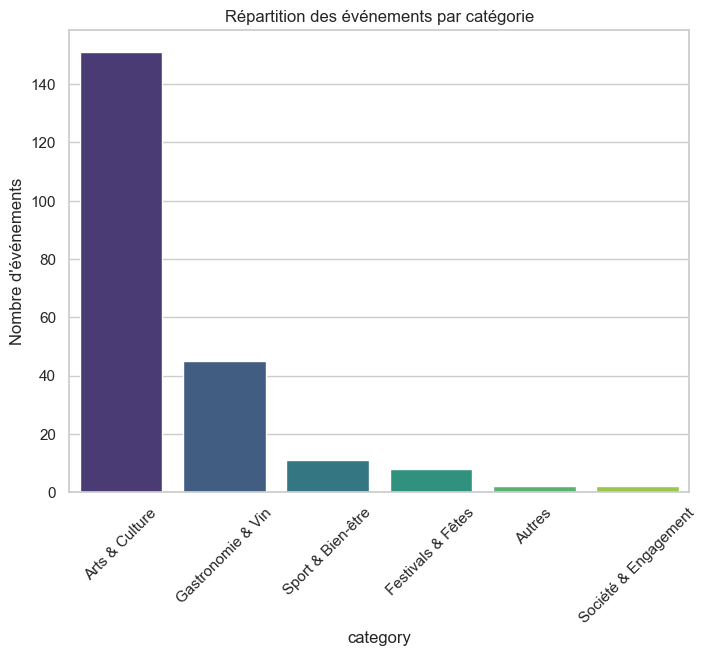

In [199]:
# R√©partition des √©v√©nements par cat√©gorie
import matplotlib.pyplot as plt
import seaborn as sns

# Cat√©gories principales
plt.figure(figsize=(8,6))
cat_count = df_clean['category'].value_counts()
sns.barplot(x=cat_count.index, y=cat_count.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("R√©partition des √©v√©nements par cat√©gorie")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/636141315.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subcat_count.index, y=subcat_count.values, palette="magma")


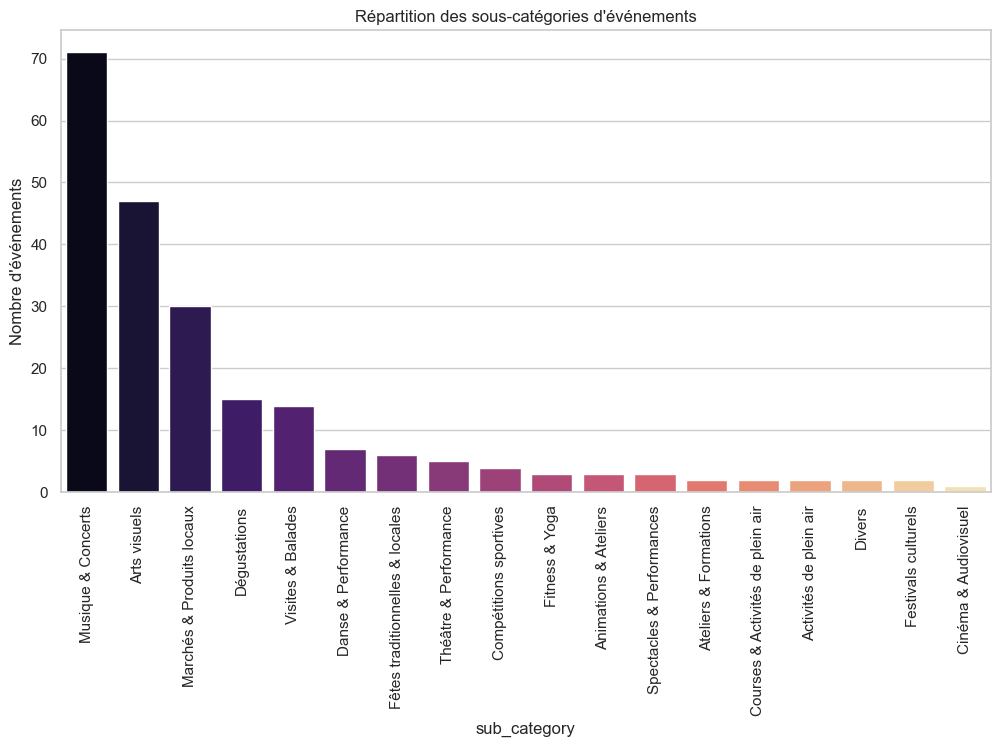

In [200]:
# R√©partition des sous-cat√©gories d'√©v√©nements
plt.figure(figsize=(12,6))
subcat_count = df_clean['sub_category'].value_counts()
sns.barplot(x=subcat_count.index, y=subcat_count.values, palette="magma")
plt.xticks(rotation=90)
plt.title("R√©partition des sous-cat√©gories d'√©v√©nements")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()

**Insights :**
La cat√©gorie la plus fr√©quente montre les th√©matiques dominantes √† Bordeaux:Musique et concerts .Elle permet de cibler et matcher entre les preferences clients et les evennements pour avoir une meilleure exp√©rience utilisateur dans le plateforme. 

**R√©partition par type de sortie**
Cette analyse montre le type de public vis√© : en famille, entre amis, professionnel, √©tudiant‚Ä¶ Cela aide √† adapter le marketing et les recommandations selon le type de sortie cherch√©e depuis l'utilisateur.


/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/4089379939.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_count.index, y=type_count.values, palette="coolwarm")


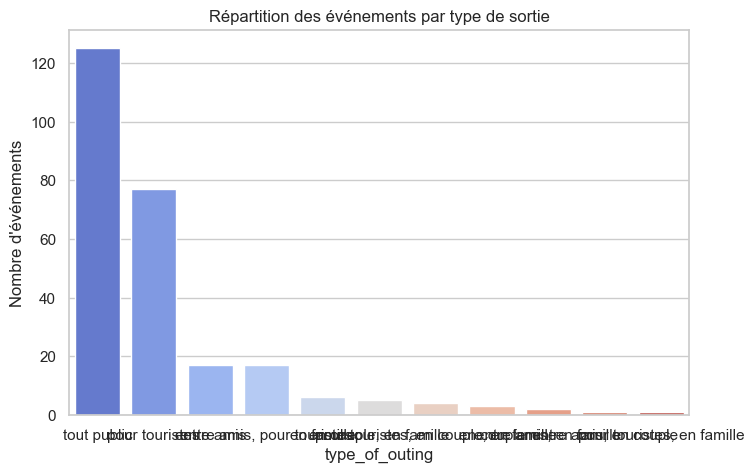

In [201]:
# R√©partition par type de sortie
plt.figure(figsize=(8,5))
type_count = df_clean['type_of_outing'].value_counts()
sns.barplot(x=type_count.index, y=type_count.values, palette="coolwarm")
plt.title("R√©partition des √©v√©nements par type de sortie")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()


**√âv√©nements gratuits vs payants**
Cette visualisation permet de voir l‚Äôaccessibilit√© financi√®re des √©v√©nements.

2025-08-31 21:52:38,601 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/756004770.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='is_free', palette='Set2')
2025-08-31 21:52:38,604 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


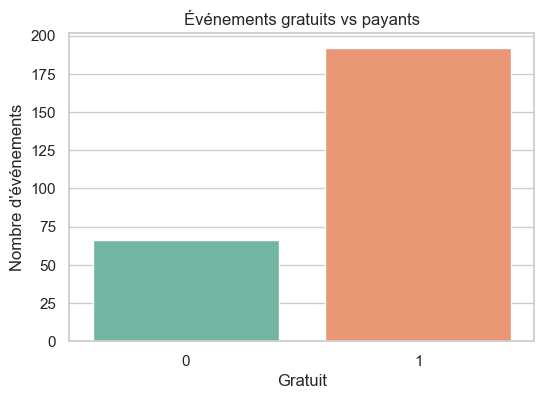

In [202]:
# √âv√©nements gratuits vs payants
plt.figure(figsize=(6,4))
sns.countplot(data=df_clean, x='is_free', palette='Set2')
plt.title("√âv√©nements gratuits vs payants")
plt.xlabel("Gratuit")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()


**Distribution des prix des √©v√©nements**
Le boxplot permet d‚Äôidentifier les cat√©gories les plus ch√®res et les plus abordables. Cela aide √† comprendre le positionnement des √©v√©nements

**Distribution par type de r√©servation**
Cette analyse montre les d√©tail de r√©servation (en ligne, sur place, sans r√©servation)

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/4011050410.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='reservation_type', order=df_clean['reservation_type'].value_counts().index, palette='Set1')


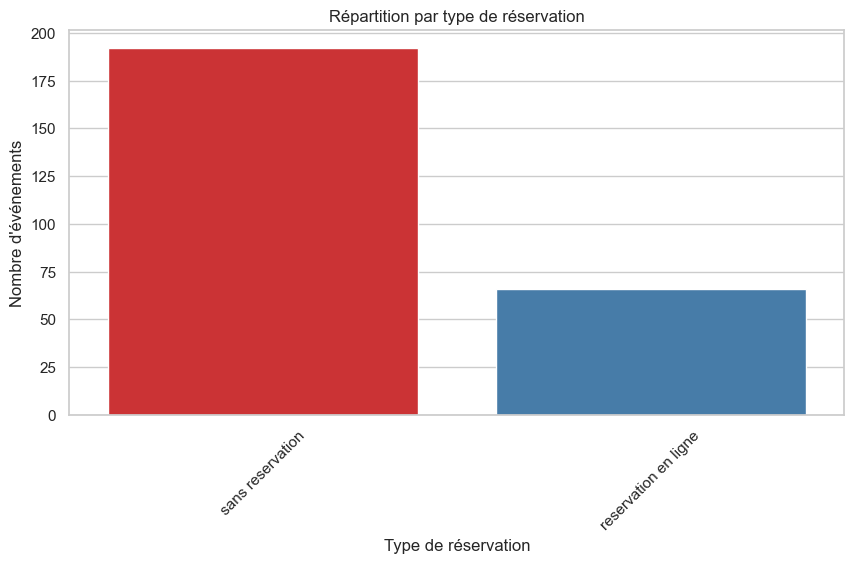

In [203]:
# Distribution des prix des √©v√©nements
plt.figure(figsize=(10,5))
sns.countplot(data=df_clean, x='reservation_type', order=df_clean['reservation_type'].value_counts().index, palette='Set1')
plt.title("R√©partition par type de r√©servation")
plt.xlabel("Type de r√©servation")
plt.ylabel("Nombre d'√©v√©nements")
plt.xticks(rotation=45)
plt.show()


**Distribution temporelle globale**
On peut identifier les jours de forte activit√© 

In [204]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'reservation_type', 'schedule', 'season',
       'tags', 'ticket_url', 'time', 'title', 'sub_category', 'cible',
       'type_of_outing', 'age_range', 'is_touristic', 'corrected_address',
       'latitude', 'longitude', 'geometry'],
      dtype='object')

**Distribution par saison**
Cette visualisation permet d‚Äôidentifier si les √©vennements pr√©sents sont saisonnieres ou plutot sur tout l'ann√©e.


/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3195938147.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_counts.index, y=season_counts.values, palette="summer")


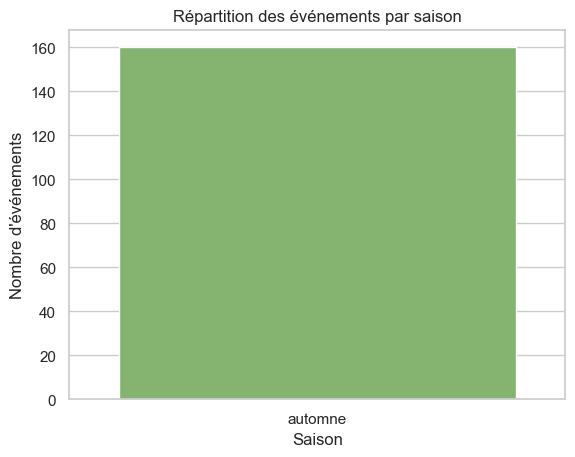

In [205]:
season_counts = df_clean['season'].value_counts()
sns.barplot(x=season_counts.index, y=season_counts.values, palette="summer")
plt.title("R√©partition des √©v√©nements par saison")
plt.xlabel("Saison")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()


### Analyse Temporelle 

Pour faire l'analyse temporelle ,on commence par creer une dataframe d'analyse temporelle :Cette transformation permet d‚Äôanalyser les √©v√©nements jour par jour, plut√¥t que par √©v√©nement global. 


In [208]:
import ast

def explode_schedule(df):
    """
    Transforme la colonne 'schedule' en lignes s√©par√©es avec date, weekday, start_time, end_time
    """
    from ast import literal_eval
    import json
    from pandas import json_normalize
    
    df_temp = []
    
    for idx, row in df.iterrows():
        schedule_data = row.get('schedule')
    
    # V√©rifier si schedule n'est pas vide
        if schedule_data is None or (isinstance(schedule_data, (list, str)) and len(schedule_data) == 0) or (isinstance(schedule_data, str) and not schedule_data.strip()):
            continue

        try:
            # Essayer de parser comme JSON d'abord
            try:
                if isinstance(schedule_data, str):
                    events = json.loads(schedule_data)
                else:
                    events = schedule_data
            except:
                # Si √©chec, essayer avec literal_eval
                events = literal_eval(str(schedule_data))
            
            # V√©rifier si events est une liste
            if not isinstance(events, list):
                continue
                
            for event in events:
                if not isinstance(event, dict):
                    continue
                    
                new_row = {
                    'event_id': row.get('event_id'),
                    'title': row.get('title'),
                    'category': row.get('category'),
                    'subcategory': row.get('subcategory'),
                    'date': event.get('date'),
                    'day_of_week': event.get('weekday'),
                    'start_time': event.get('start_time'),
                    'end_time': event.get('end_time'),
                    'is_weekend': event.get('weekday') in ['Samedi', 'Dimanche'],
                    'is_free': row.get('is_free'),
                    'type_of_outing': row.get('type_of_outing'),
                    'cible': row.get('cible'),
                    'age_range': row.get('age_range')
                }
                df_temp.append(new_row)
                
        except Exception as e:
            print(f"Erreur √† la ligne {idx}: {str(e)}")
            continue
    
    if not df_temp:
        return pd.DataFrame()
    
    df_sched = pd.DataFrame(df_temp)
    
    # Nettoyage et conversion des dates
    if 'date' in df_sched.columns:
        df_sched['date'] = pd.to_datetime(df_sched['date'], errors='coerce')
    
    return df_sched

df_schedule = explode_schedule(df_clean)
df_schedule.head()


event_id               title        category  \
0  4f29c1ab26128fcfdb70a0176807d325  exposition  pollen  Arts & Culture   
1  4f29c1ab26128fcfdb70a0176807d325  exposition  pollen  Arts & Culture   
2  4f29c1ab26128fcfdb70a0176807d325  exposition  pollen  Arts & Culture   
3  4f29c1ab26128fcfdb70a0176807d325  exposition  pollen  Arts & Culture   
4  4f29c1ab26128fcfdb70a0176807d325  exposition  pollen  Arts & Culture   

  subcategory       date day_of_week start_time end_time  is_weekend  is_free  \
0        None 2025-09-02     Tuesday      11h00    18h00       False        0   
1        None 2025-09-03   Wednesday      11h00    18h00       False        0   
2        None 2025-09-04    Thursday      11h00    18h00       False        0   
3        None 2025-09-05      Friday      11h00    18h00       False        0   
4        None 2025-09-06    Saturday      11h00    18h00       False        0   

  type_of_outing         cible        age_range  
0    tout public  grand public  adults, seniors  
1    tout public  grand public  adults, seniors  
2    tout public  grand public  adults, seniors  
3    tout public  grand public  adults, seniors  
4    tout public  grand public  adults, seniors

**Distribution par jour de la semaine**
Cette analyse permet de d√©tecter les jours les plus actifs.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/766055763.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=df_schedule, order=['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'], palette="Set2")


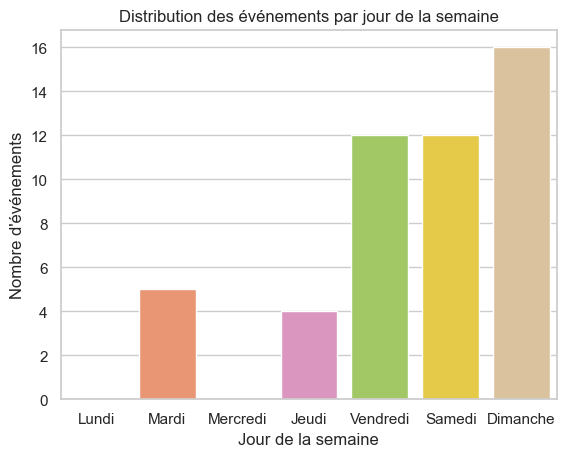

In [209]:
#Distribution par jour de la semaine
sns.countplot(x='day_of_week', data=df_schedule, order=['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'], palette="Set2")
plt.title("Distribution des √©v√©nements par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()


**Distribution week-end vs semaine**
Permet de mesurer la proportion des √©v√©nements organis√©s le week-end.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3446503980.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_weekend', data=df_schedule, palette="Set1")


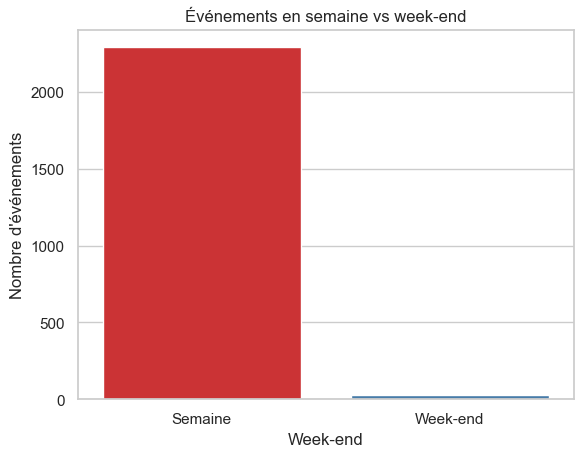

In [210]:
sns.countplot(x='is_weekend', data=df_schedule, palette="Set1")
plt.title("√âv√©nements en semaine vs week-end")
plt.xlabel("Week-end")
plt.ylabel("Nombre d'√©v√©nements")
plt.xticks([0,1], ['Semaine','Week-end'])
plt.show()


**Distribution par cr√©neau horaire**
Cette analyse montre quand les √©v√©nements se d√©roulent.Il permet de faire cibler les client√®les selon leurs heurs de recherche

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/1212941728.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='time_slot', data=df_schedule, palette="Paired")


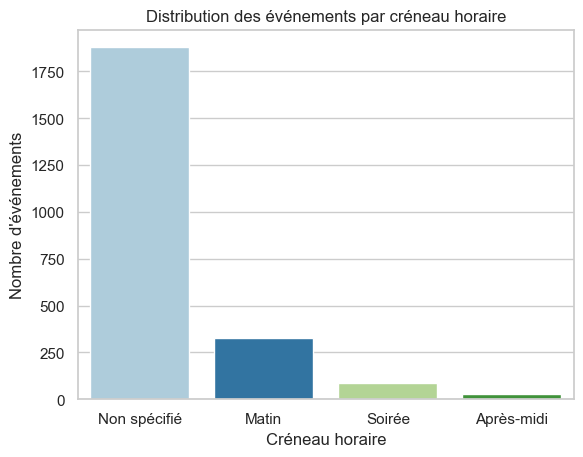

In [211]:
# fonction pour cat√©goriser le temps
def categorize_time(t):
    try:
        hour = int(t.split(':')[0])
        if 6 <= hour < 12:
            return 'Matin'
        elif 12 <= hour < 18:
            return 'Apr√®s-midi'
        elif 18 <= hour <= 23:
            return 'Soir√©e'
        else:
            return 'Nuit'
    except:
        return 'Non sp√©cifi√©'

df_schedule['time_slot'] = df_schedule['start_time'].apply(categorize_time)

sns.countplot(x='time_slot', data=df_schedule, palette="Paired")
plt.title("Distribution des √©v√©nements par cr√©neau horaire")
plt.xlabel("Cr√©neau horaire")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()


**Temporalit√© par type de sortie**
On peut visualiser quels types de sortie se produisent √† quels moments (ex: sorties en famille surtout l‚Äôapr√®s-midi, √©v√©nements professionnels en matin√©e). Aide √† la segmentation de l‚Äôaudience.


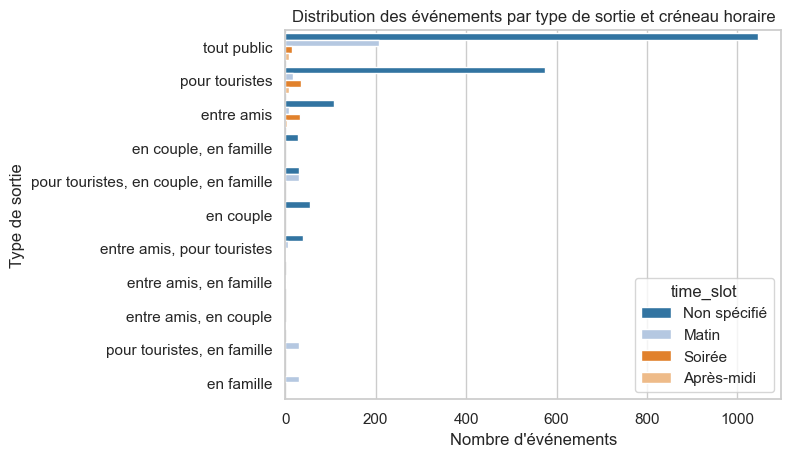

In [212]:
sns.countplot(y='type_of_outing', hue='time_slot', data=df_schedule, palette="tab20")
plt.title("Distribution des √©v√©nements par type de sortie et cr√©neau horaire")
plt.xlabel("Nombre d'√©v√©nements")
plt.ylabel("Type de sortie")
plt.show()


**√âv√©nements r√©currents vs ponctuels**
Permet de d√©tecter les √©v√©nements r√©currents (quotidiens) cela permet de faire cibl√© l'importanace et les faisabilit√©s des √©v√©nements


2025-08-31 21:52:39,188 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3859631963.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_daily', data=df_clean, palette="muted")
2025-08-31 21:52:39,192 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


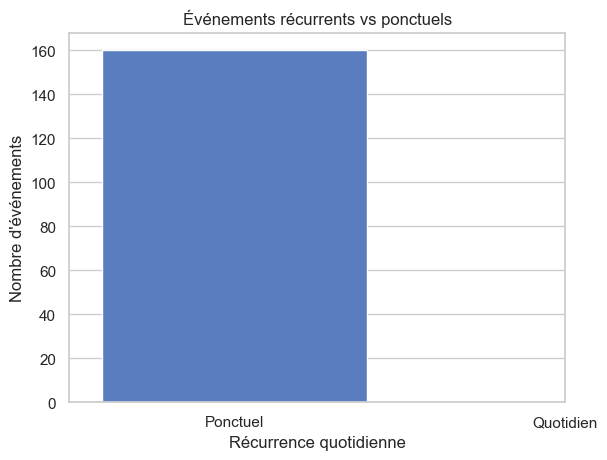

In [213]:
sns.countplot(x='is_daily', data=df_clean, palette="muted")
plt.title("√âv√©nements r√©currents vs ponctuels")
plt.xlabel("R√©currence quotidienne")
plt.ylabel("Nombre d'√©v√©nements")
plt.xticks([0,1], ['Ponctuel', 'Quotidien'])
plt.show()


**Temporalit√© des √©v√©nements selon les cat√©gories**
On peut identifier quels types d'√©v√©nements sont concentr√©s certains jours. 


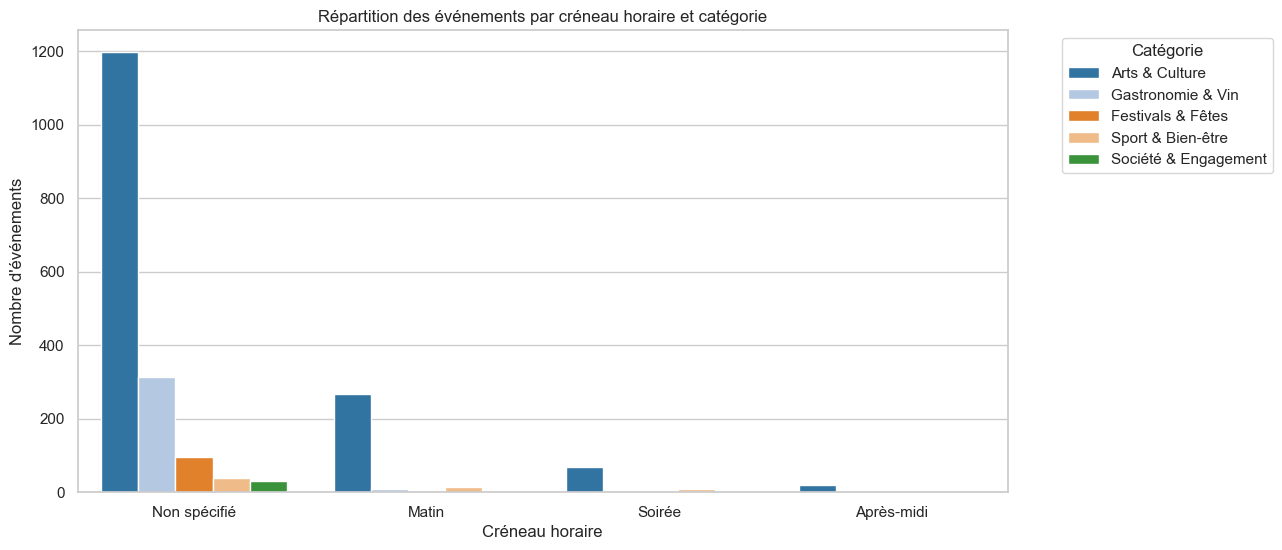

In [214]:
# Distribution par cr√©neau horaire pour chaque cat√©gorie
plt.figure(figsize=(12,6))
sns.countplot(x='time_slot', hue='category', data=df_schedule, palette="tab20")
plt.title("R√©partition des √©v√©nements par cr√©neau horaire et cat√©gorie")
plt.xlabel("Cr√©neau horaire")
plt.ylabel("Nombre d'√©v√©nements")
plt.legend(title="Cat√©gorie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Analyse g√©ographique

cet analyse nous permet de comprendre la r√©partition spatiale des √©v√©nements √† Bordeaux, d√©tecter les lieux les plus actifs, identifier des zones chaudes

**R√©partition des √©v√©nements sur la carte de Bordeaux**
Cette visualisation permet d‚Äôidentifier rapidement la densit√© des √©v√©nements.  
On peut voir quelles zones sont tr√®s actives et celles moins couvertes.

In [215]:
import folium
from folium.plugins import MarkerCluster

# Centrer la carte sur Bordeaux
bordeaux_lat, bordeaux_lon = 44.8378, -0.5792
m = folium.Map(location=[bordeaux_lat, bordeaux_lon], zoom_start=13)

# Cluster pour regrouper les markers proches
marker_cluster = MarkerCluster().add_to(m)

# Filtrer uniquement les lignes avec latitude et longitude valides
df_valid = df_clean.dropna(subset=['latitude', 'longitude'])

# Ajouter les √©v√©nements
for idx, row in df_valid.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    title = row.get('title', '√âv√©nement')
    # Assurer que ce sont des floats
    try:
        lat = float(lat)
        lon = float(lon)
        folium.Marker(
            location=[lat, lon],
            popup=title,
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)
    except ValueError:
        continue

# Afficher la carte
m


**Lieux les plus actifs**
Certaines adresses ou lieux concentrent beaucoup d'√©v√©nements.Cela nous permet de plus cibler et recommander les √©v√©nements selon la localisation du clients et les evennements qu'il peut les rejoindre selon sa localisation.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3184698289.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")


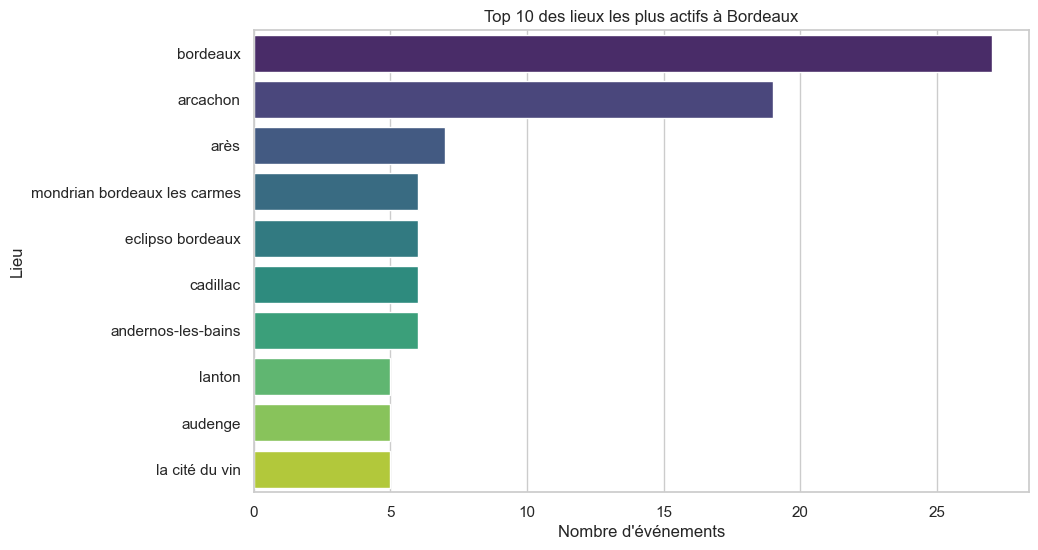

In [216]:
top_locations = df_clean['location'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("Top 10 des lieux les plus actifs √† Bordeaux")
plt.xlabel("Nombre d'√©v√©nements")
plt.ylabel("Lieu")
plt.show()


**Distance aux points d‚Äôint√©r√™t**
Mesurer la proximit√© des √©v√©nements avec les universit√©s, h√¥tels, lieux touristiques permet d‚Äô√©valuer l‚Äôattractivit√© et le ciblage du public.


In [217]:
from geopy.distance import geodesic

# D√©finir les Points d‚ÄôInt√©r√™t (POIs) dans Bordeaux


POINTS_OF_INTEREST = {
    'universite_bordeaux': 'Universit√© de Bordeaux, 33000 Bordeaux',
    'gare_saint_jean': 'Gare Saint-Jean, Bordeaux',
    'place_de_la_bourse': 'Place de la Bourse, Bordeaux',
    'pey_berland': 'Place Pey Berland, Bordeaux',
    'cite_du_vin': 'La Cit√© du Vin, Bordeaux',
    'stade_matmut': 'Stade Matmut Atlantique, Bordeaux',
    'aeroport': 'A√©roport de Bordeaux-M√©rignac',
    'hotel_de_ville': 'H√¥tel de Ville de Bordeaux',
    'jardin_public': 'Jardin Public, Bordeaux',
    'capc': "CAPC Mus√©e d'art contemporain, Bordeaux"
}

In [218]:
# G√©ocoder les POIs

def geocode_pois(pois_dict):
    coords = {}
    for name, address in pois_dict.items():
        try:
            loc = geolocator.geocode(address + ", France", timeout=10)
            if loc:
                coords[name] = (loc.latitude, loc.longitude)
            else:
                coords[name] = (None, None)
        except:
            coords[name] = (None, None)
        time.sleep(1)  # respecter quotas Nominatim
    return coords

POIS_COORDS = geocode_pois(POINTS_OF_INTEREST)

In [219]:
from geopy.distance import geodesic
import pandas as pd

# Exemple de POIs
POIS_COORDS = {
    "Place de la Bourse": (44.8412, -0.5700),
    "Miroir d'eau": (44.8410, -0.5690),
    "Grand Th√©√¢tre": (44.8379, -0.5754)
}

def distance_to_pois(event_coords, pois):
    """
    Retourne un dict des distances de l'√©v√©nement √† chaque POI.
    Si event_coords contient None ou NaN, renvoie None pour chaque POI.
    """
    # V√©rifier que event_coords est un tuple/list de 2 √©l√©ments valides
    if (not isinstance(event_coords, (tuple, list)) 
        or len(event_coords) != 2 
        or any([pd.isna(c) for c in event_coords])):  # <- correction ici
        return {poi: None for poi in pois.keys()}

    distances = {}
    for poi_name, poi_coords in pois.items():
        if poi_coords and not any([pd.isna(c) for c in poi_coords]):
            distances[poi_name] = geodesic(event_coords, poi_coords).kilometers
        else:
            distances[poi_name] = None
    return distances


# Calcul s√©curis√©
df_clean["poi_distances"] = df_clean.apply(
    lambda row: distance_to_pois((row["latitude"], row["longitude"]), POIS_COORDS),
    axis=1
)

# Trouver le POI le plus proche
def closest_poi(distances):
    if not distances:
        return None, None
    valid_distances = {k: v for k, v in distances.items() if v is not None}
    if not valid_distances:
        return None, None
    poi, dist = min(valid_distances.items(), key=lambda x: x[1])
    return poi, dist

df_clean[["closest_poi", "closest_dist_km"]] = df_clean["poi_distances"].apply(
    lambda d: pd.Series(closest_poi(d))
)


closest_poi
Grand Th√©√¢tre         54
Miroir d'eau          37
Place de la Bourse    27
Name: count, dtype: int64


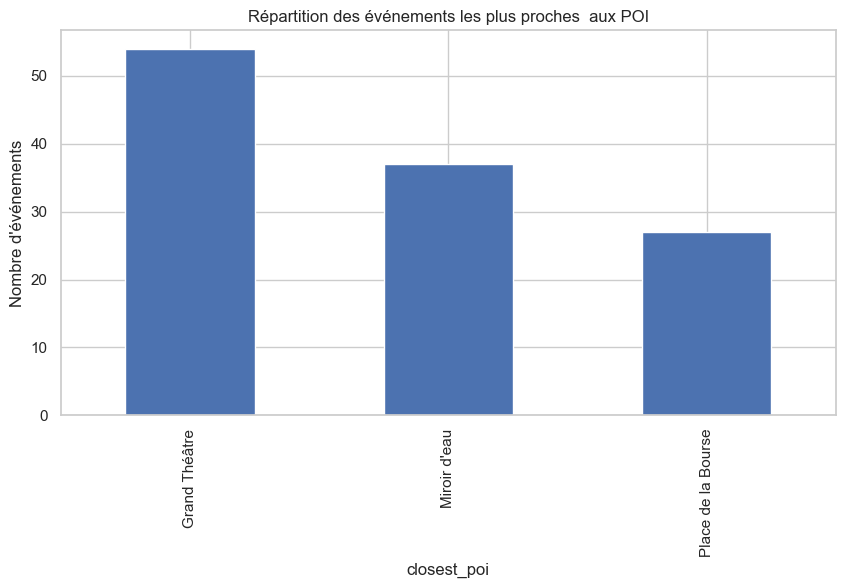

In [220]:

print(df_clean["closest_poi"].value_counts())


import matplotlib.pyplot as plt

df_clean["closest_poi"].value_counts().plot(kind="bar", figsize=(10,5))
plt.title("R√©partition des √©v√©nements les plus proches  aux POI")
plt.ylabel("Nombre d'√©v√©nements")
plt.show()

In [221]:
m = folium.Map(location=[44.84, -0.58], zoom_start=12)

# Ajouter les POIs
for name, coords in POIS_COORDS.items():
    if coords[0] is not None and coords[1] is not None:
        folium.Marker(
            coords,
            popup=f"{name}",
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(m)

# Ajouter les √©v√©nements uniquement avec des coordonn√©es valides
df_valid = df_clean.dropna(subset=["latitude", "longitude"])

for _, row in df_valid.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        popup=f"{row['title']} ({row.get('closest_poi')}, {row.get('closest_dist_km', 0):.2f} km)",
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m

**heatmap des √©v√©nements touristiques**

In [222]:
from folium.plugins import HeatMap

touristic_events = df_clean[df_clean['is_touristic'] == True]

# V√©rifier qu'il y a bien des coordonn√©es valides
touristic_coords = touristic_events[['latitude', 'longitude']].dropna()

# Convertir en liste de tuples pour HeatMap
heat_data = list(zip(touristic_coords['latitude'], touristic_coords['longitude']))

m_touristic = folium.Map(location=[44.84, -0.58], zoom_start=12)

# Ajouter les POIs
for name, coords in POIS_COORDS.items():
    if coords[0] is not None:
        folium.Marker(
            location=coords,
            popup=f"{name}",
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(m_touristic)

# -------------------------------
# 3Ô∏è‚É£ Ajouter la heatmap pour les √©v√©nements touristiques
# -------------------------------
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m_touristic)

# -------------------------------
# 4Ô∏è‚É£ Sauvegarder et afficher
# -------------------------------
m_touristic.save("heatmap_touristic_events.html")
m_touristic


### Analyse ciblage / audience

Cet analyse nous permet de comprendre √† qui s‚Äôadressent les √©v√©nements, quelles tranches d‚Äô√¢ge sont vis√©es, la proportion de gratuit√©

**R√©partition par public cible**
Cette visualisation permet d‚Äôidentifier les publics majoritairement vis√©s ,√ßa nous aide pour bien cibl√© et facilit√© et personnalis√© la presence des evennement dans le plateforme selon les informations client .


/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3932309391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, y='cible', order=df_clean['cible'].value_counts().index, palette='viridis')


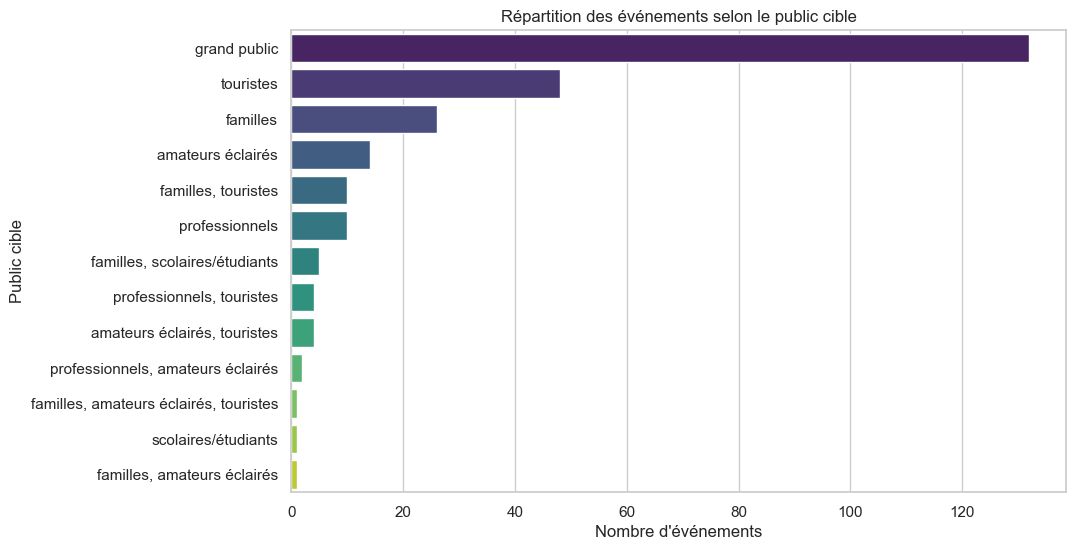

In [223]:


plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, y='cible', order=df_clean['cible'].value_counts().index, palette='viridis')
plt.title("R√©partition des √©v√©nements selon le public cible")
plt.xlabel("Nombre d'√©v√©nements")
plt.ylabel("Public cible")
plt.show()

**R√©partition par tranche d'√¢ge**
Permet de comprendre l‚Äô√¢ge moyen du public vis√© pour diff√©rents types d‚Äô√©v√©nements .cela nous aide √† matcher les √©v√©nements futures avec le public vis√© .

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/840414093.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, y='age_range', order=df_clean['age_range'].value_counts().index, palette='coolwarm')


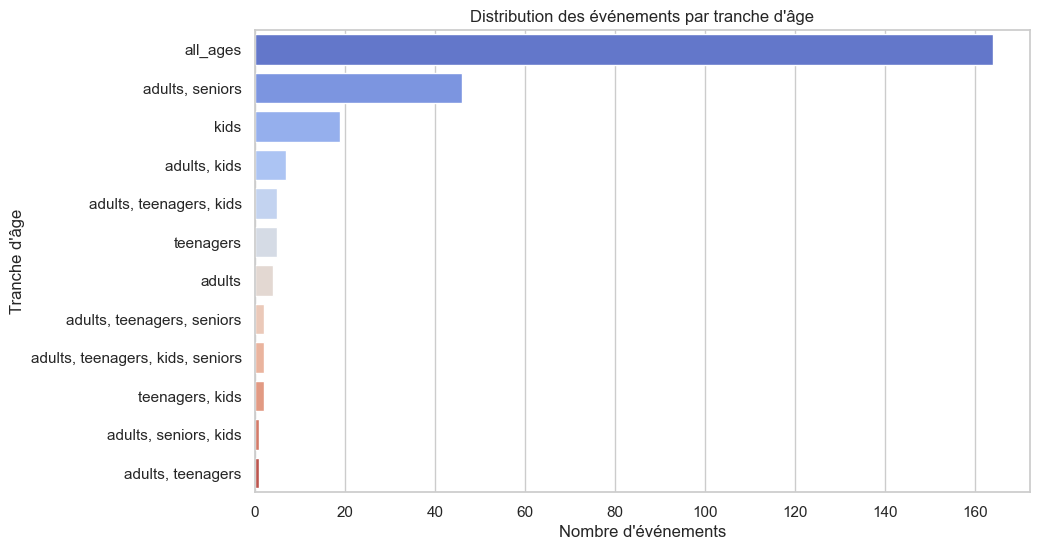

In [224]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, y='age_range', order=df_clean['age_range'].value_counts().index, palette='coolwarm')
plt.title("Distribution des √©v√©nements par tranche d'√¢ge")
plt.xlabel("Nombre d'√©v√©nements")
plt.ylabel("Tranche d'√¢ge")
plt.show()

**Gratuit√© vs Public cible**
Permet d‚Äôidentifier quelles audiences b√©n√©ficient le plus d‚Äô√©v√©nements gratuits.cela nous aide √† faire recommandations sur les √©v√©nements gratuits √† organiser pour chaque trance d'age.

2025-08-31 21:52:54,907 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-31 21:52:54,910 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


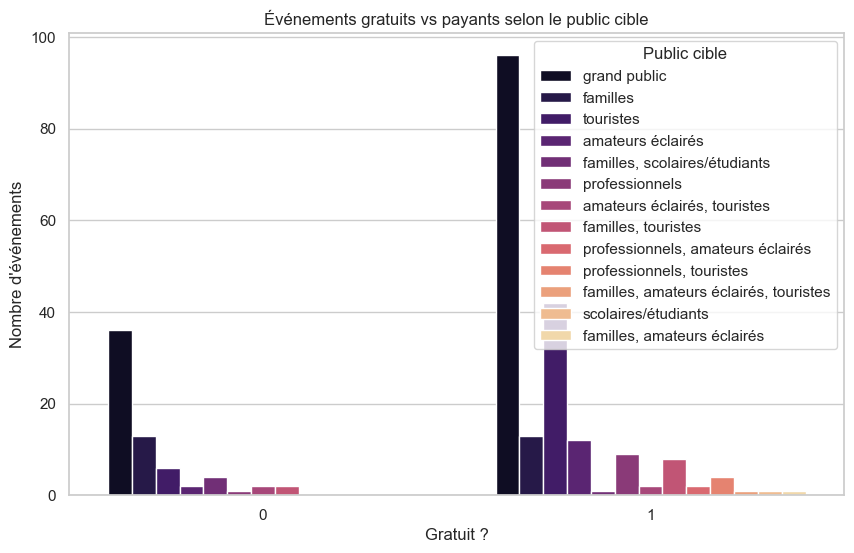

In [225]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, x='is_free', hue='cible', palette='magma')
plt.title("√âv√©nements gratuits vs payants selon le public cible")
plt.xlabel("Gratuit ?")
plt.ylabel("Nombre d'√©v√©nements")
plt.legend(title='Public cible')
plt.show()

**Cat√©gorie vs Tranche d‚Äô√¢ge**
Permet d‚Äôidentifier  la r√©partition des √©v√©nements par cat√©gorie et voir quels tranches d‚Äô√¢ge sont le plus int√©ress√©s.

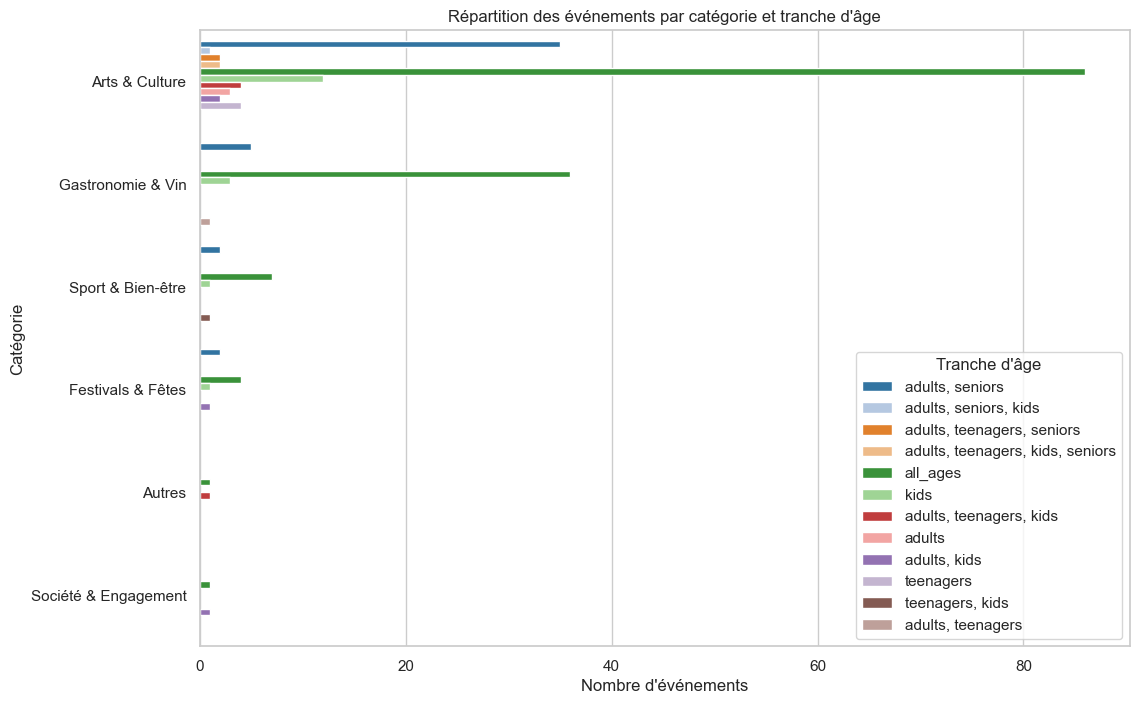

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.countplot(
    data=df_clean,
    y='category',
    hue='age_range',
    order=df_clean['category'].value_counts().index,
    palette='tab20'
)
plt.title("R√©partition des √©v√©nements par cat√©gorie et tranche d'√¢ge")
plt.xlabel("Nombre d'√©v√©nements")
plt.ylabel("Cat√©gorie")
plt.legend(title="Tranche d'√¢ge")
plt.show()

**Cat√©gorie vs Tranche d‚Äô√¢ge**
Permet d‚Äôidentifier  la r√©partition des √©v√©nements par cat√©gorie et voir quels publics sont le plus int√©ress√©s.

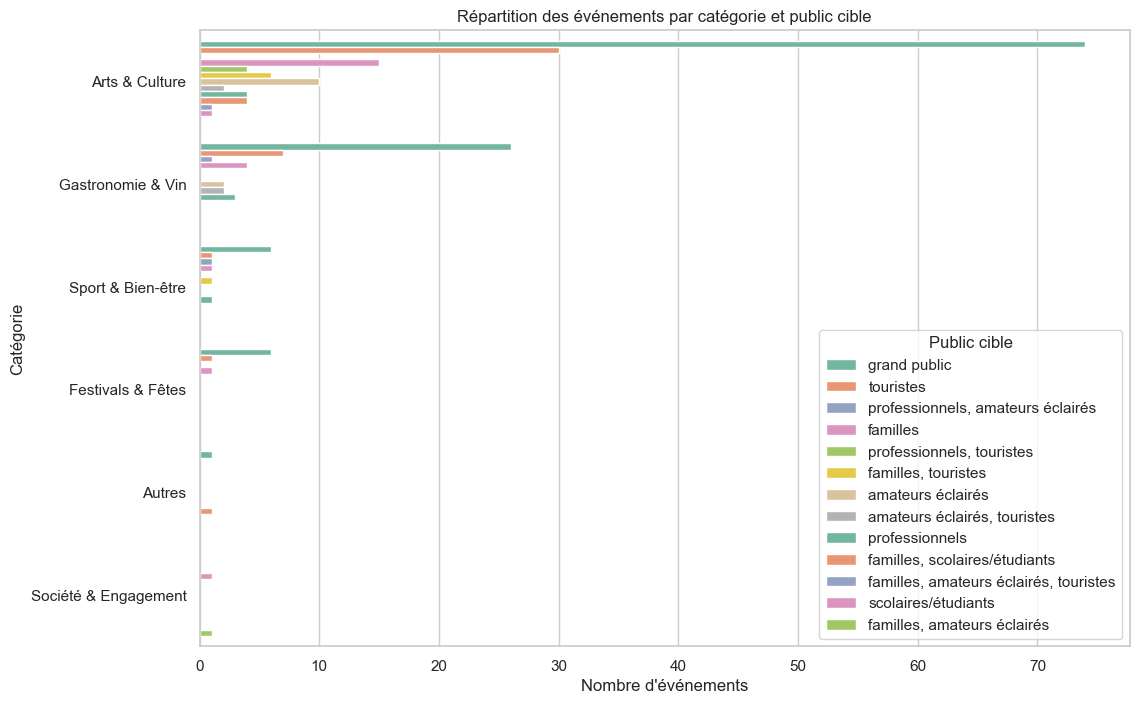

In [227]:
plt.figure(figsize=(12,8))
sns.countplot(
    data=df_clean,
    y='category',
    hue='cible',
    order=df_clean['category'].value_counts().index,
    palette='Set2'
)
plt.title("R√©partition des √©v√©nements par cat√©gorie et public cible")
plt.xlabel("Nombre d'√©v√©nements")
plt.ylabel("Cat√©gorie")
plt.legend(title="Public cible")
plt.show()

In [228]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'reservation_type', 'schedule', 'season',
       'tags', 'ticket_url', 'time', 'title', 'sub_category', 'cible',
       'type_of_outing', 'age_range', 'is_touristic', 'corrected_address',
       'latitude', 'longitude', 'geometry', 'poi_distances', 'closest_poi',
       'closest_dist_km'],
      dtype='object')

## Proposition:syst√®me de recommandation bas√© sur chatbot pour Meeting Potes

L‚Äôid√©e est de proposer une exp√©rience personnalis√©e √† chaque utilisateur de Meeting Potes en lui sugg√©rant les √©v√©nements les plus pertinents √† Bordeaux selon ses pr√©f√©rences :

Cat√©gorie et sous-cat√©gorie (concerts, spectacles, expositions, activit√©s familiales‚Ä¶)

Budget et gratuit√© des √©v√©nements

Tranche d‚Äô√¢ge et public cible

Localisation (proximit√© g√©ographique)

Jour et horaire pr√©f√©r√©s

Le syst√®me utilise un score de matching calcul√© pour chaque √©v√©nement, combinant diff√©rents crit√®res pond√©r√©s.

Collecte des pr√©f√©rences utilisateur via un chatbot interactif :

Cat√©gories / sous-cat√©gories

Budget maximum

Tranche d‚Äô√¢ge

Jours pr√©f√©r√©s

Calcul du score de matching :

Cat√©gorie / sous-cat√©gorie : pertinence des √©v√©nements par rapport aux go√ªts.

Distance : √©v√©nements proches de l‚Äôutilisateur ou zones d‚Äôint√©r√™t (POIs).

Budget : gratuit√© ou prix ‚â§ budget utilisateur.

Age : correspondance avec la tranche d‚Äô√¢ge cible de l‚Äô√©v√©nement.

Timing : √©v√©nements aux jours pr√©f√©r√©s.

Les scores sont pond√©r√©s pour refl√©ter l‚Äôimportance de chaque crit√®re.

Classement des √©v√©nements par score et affichage des top recommandations :



Infos d√©taill√©es : titre, cat√©gorie, prix, adresse, lien billetterie.

In [229]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
# On normalise les prix pour uniformiser les calculs de score et g√©rer les √©v√©nements gratuits.
def parse_price(price):
    """
    Convertit une valeur de prix en float.
    Retourne 0 si 'Gratuit' ou non convertible.
    """
    if pd.isna(price):
        return 0.0
    if isinstance(price, str):
        price = price.replace('‚Ç¨','').replace(',','').strip().lower()
        if price in ['gratuit','free','n/a','']:
            return 0.0
    try:
        return float(price)
    except:
        return 0.0



In [230]:
# focntion de scoring:Le scoring est multi-crit√®res pour refl√©ter la pertinence globale
def compute_event_score(event, user_pref, weights):
    score = 0
    
    # Cat√©gorie / sous-cat√©gorie
    cat_match = 1 if str(event.get('category','')).lower() in user_pref.get('categories', []) else 0
    subcat_match = 1 if str(event.get('sub_category','')).lower() in user_pref.get('sub_categories', []) else 0
    score += weights['category'] * (0.7*cat_match + 0.3*subcat_match)
    
    # Distance (proximit√© g√©ographique)
    if 'location' in user_pref and event.get('latitude') and event.get('longitude'):
        user_loc = user_pref['location']
        event_loc = (event['latitude'], event['longitude'])
        try:
            dist_km = geodesic(user_loc, event_loc).km
            dist_score = max(0, 1 - dist_km / 10)  # Score d√©croissant avec distance
        except:
            dist_score = 0
        score += weights['distance'] * dist_score
    
    # Budget / gratuit√©
    avg_price = parse_price(event.get('avg_price', 0))
    max_budget = user_pref.get('budget', np.inf)
    if event.get('is_free', False) and max_budget == 0:
        score += weights['budget']
    else:
        budget_score = max(0, 1 - avg_price / max_budget) if max_budget else 0
        score += weights['budget'] * budget_score
    
    # Tranche d'√¢ge
    if 'age_range' in user_pref and event.get('age_range'):
        try:
            if '-' in event['age_range']:
                e_min, e_max = map(int, event['age_range'].split('-'))
            else:
                e_min = e_max = int(event['age_range'])
            u_min, u_max = user_pref['age_range']
            overlap = max(0, min(e_max,u_max) - max(e_min,u_min))
            age_score = overlap / (e_max - e_min + 1) if (e_max - e_min) > 0 else 1
            score += weights['age'] * age_score
        except:
            pass
    
    # Timing
    if 'day_of_week' in user_pref:
        score += weights['timing'] * (1 if event.get('day_of_week') in user_pref['day_of_week'] else 0)
    
    return score


L‚Äôutilisateur peut choisir un point de r√©f√©rence √† Bordeaux plut√¥t que de rentrer manuellement latitude/longitude.

In [231]:
from geopy.geocoders import Nominatim

# Points d'int√©r√™t pr√©d√©finis
POINTS_OF_INTEREST = {
    'universite_bordeaux': 'Universit√© de Bordeaux, 33000 Bordeaux',
    'gare_saint_jean': 'Gare Saint-Jean, Bordeaux',
    'place_de_la_bourse': 'Place de la Bourse, Bordeaux',
    'pey_berland': 'Place Pey Berland, Bordeaux',
    'cite_du_vin': 'La Cit√© du Vin, Bordeaux',
    'stade_matmut': 'Stade Matmut Atlantique, Bordeaux',
    'aeroport': 'A√©roport de Bordeaux-M√©rignac',
    'hotel_de_ville': 'H√¥tel de Ville de Bordeaux',
    'jardin_public': 'Jardin Public, Bordeaux',
    'capc': "CAPC Mus√©e d'art contemporain, Bordeaux"
}

geolocator = Nominatim(user_agent="geo_events")

def get_location_from_poi(poi_name):
    """
    Transforme le nom d'un point d'int√©r√™t en coordonn√©es (latitude, longitude)
    """
    address = POINTS_OF_INTEREST.get(poi_name.lower())
    if not address:
        return None
    loc = geolocator.geocode(address)
    if loc:
        return (loc.latitude, loc.longitude)
    return None

In [232]:
# Chatbot interactif

def event_recommendation_chatbot(df_events, weights):
    print("üëã Bonjour ! Je vais vous recommander des √©v√©nements √† Bordeaux.")
    
    # Pr√©f√©rences utilisateur
    categories = input("üí° Quelles cat√©gories vous int√©ressent ? (ex: concert, spectacle) ").split(',')
    sub_categories = input("üí° Sous-cat√©gories pr√©f√©r√©es ? (ex: musique, th√©√¢tre) ").split(',')
    budget_input = input("üí∞ Budget max (ou 'free' pour gratuit) ? ").strip().lower()
    
    if budget_input == 'free':
        max_budget = 0.0
    else:
        try:
            max_budget = float(budget_input)
        except:
            max_budget = np.inf
    
    age_input = input("üë∂ Tranche d'√¢ge ? (ex: 18-35 ou 25) ")
    try:
        if '-' in age_input:
            age_range = tuple(map(int, age_input.split('-')))
        else:
            val = int(age_input)
            age_range = (val, val)
    except:
        age_range = (0,100)
    
    day_of_week_input = input("üìÖ Jours pr√©f√©r√©s ? (ex: Vendredi, Samedi) ").split(',')
    
    # Choix du point d'int√©r√™t comme localisation
    print("\nüìç Choisissez un point de r√©f√©rence pour votre localisation :")
    for key in POINTS_OF_INTEREST:
        print(f"- {key}")
    poi_choice = input("Nom du point d'int√©r√™t (ou 'default' pour Bordeaux centre) : ").strip().lower()
    
    if poi_choice == 'default' or poi_choice not in POINTS_OF_INTEREST:
        location = (44.8378, -0.5792)  # Bordeaux centre par d√©faut
    else:
        location = get_location_from_poi(poi_choice)
        if not location:
            location = (44.8378, -0.5792)
    
    user_pref = {
        'categories': [c.strip().lower() for c in categories],
        'sub_categories': [c.strip().lower() for c in sub_categories],
        'budget': max_budget,
        'age_range': age_range,
        'day_of_week': [d.strip() for d in day_of_week_input],
        'location': location
    }
    
    # Calcul du score
    df_events['match_score'] = df_events.apply(lambda row: compute_event_score(row, user_pref, weights), axis=1)
    
    # Top 5 recommandations
    top_events = df_events.sort_values(by='match_score', ascending=False).head(5)
    
    print("\nüåü Voici les √©v√©nements recommand√©s pour vous :")
    for i, row in top_events.iterrows():
        print(f"\nüé´ {row['title']} ({row.get('category','N/A')} - {row.get('sub_category','N/A')})")
        print(f"üìç Lieu : {row.get('corrected_address','N/A')}")
        print(f"üí∞ Prix : {'Gratuit' if row.get('is_free', False) else row.get('avg_price',0)} ‚Ç¨")
        print(f"üóìÔ∏è Jour : {row.get('day_of_week','N/A')}, {row.get('date','N/A')}")
        print(f"üîó Billetterie : {row.get('ticket_url','N/A')}")
        print(f"‚≠ê Score de matching : {row['match_score']:.2f}")


weights = {
    'category': 0.3,
    'distance': 0.25,
    'budget': 0.5,
    'age': 0.45,
    'timing': 0.1
}



In [233]:
df_utilisation = df_clean.copy()
for col in ['avg_price','min_price','max_price']:
    if col in df_utilisation.columns:
        df_utilisation[col] = df_utilisation[col].apply(parse_price)

# Lancer le chatbot
event_recommendation_chatbot(df_utilisation, weights)


üëã Bonjour ! Je vais vous recommander des √©v√©nements √† Bordeaux.

üìç Choisissez un point de r√©f√©rence pour votre localisation :
- universite_bordeaux
- gare_saint_jean
- place_de_la_bourse
- pey_berland
- cite_du_vin
- stade_matmut
- aeroport
- hotel_de_ville
- jardin_public
- capc

üåü Voici les √©v√©nements recommand√©s pour vous :

üé´ visite  nocturne  de  la  cath√©drale  saint-andr√©  de  bordeaux (Arts & Culture - Visites & Balades)
üìç Lieu : pl. pey berland, 33000 bordeaux, bordeaux
üí∞ Prix : Gratuit ‚Ç¨
üóìÔ∏è Jour : Saturday, Du Mercredi 30 avril 2025 au Vendredi 14 novembre 2025
üîó Billetterie : https://cathedra.fr/billetterie/
‚≠ê Score de matching : 0.75

üé´ visite  nocturne  de  la  cath√©drale  saint-andr√©  de  bordeaux (Arts & Culture - Visites & Balades)
üìç Lieu : cath√©drale saint-andr√© pl. pey berland 33000 bordeaux
üí∞ Prix : Gratuit ‚Ç¨
üóìÔ∏è Jour : Monday, 30 avril - 14 novembre
üîó Billetterie : https://cathedra.fr/billetterie/
‚≠ê Sco